In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import shutil
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import time
import dask.bag as db
import dask.diagnostics as dd
import random
from termcolor import colored
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M, EfficientNetV2B0, EfficientNetV2B3, Xception, ResNet50
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score

2024-10-13 10:21:32.889844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 10:21:32.889912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 10:21:32.889939: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 10:21:32.897641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CWD = os.getcwd()
CWD

'/workspace'

In [3]:
EPOCHS = 10
SAVE_DIRECTORY = CWD + '/model'

# Load Data

In [38]:
BASE_DIR = CWD + '/dataset/testing/Training'

In [39]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(BASE_DIR)]
classes

['pituitary', 'notumor', 'meningioma', 'glioma']

In [40]:
# Convert our data to tensorflow dataset by keras.utils.image_dataset_from_directory
train_full = tf.keras.utils.image_dataset_from_directory(
    directory=BASE_DIR,        # Path of base directory
    labels='inferred',         # to generate labels from the directory structure
    label_mode='categorical',  # type of labels
    class_names=classes,       # list of class_names
    seed=42,                   # Optional random seed for shuffling and transformations
    batch_size=32,              # Define batch size
    image_size=(224, 224)      # Size to resize images to after they are read from disk
 )

Found 5712 files belonging to 4 classes.


In [41]:
train_full = train_full.prefetch(tf.data.AUTOTUNE)

In [42]:
# Counting number of all batches in dataset
num_of_full_train_batches = len(list(train_full))
print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))

# Define variable to store number of batches for train dataset
num_train_batches = int(num_of_full_train_batches * 0.70)
# Define variable to store number of batches for validation and test dataset
num_valid_test_batches = num_of_full_train_batches - num_train_batches

# Print the TARGET : number of batches for train, validation and test dataset to each
print(colored(' Target : ', 'green', attrs=['bold']))
print('-'*35)
print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

Number of batches in train_full : 179
 Target : 
-----------------------------------
Number of  Train  batches : 125
Number of Validation batches : 27
Number of Test batches : 27


In [43]:
# Apply above settings to main dataset to split to train, validation and test dataset
train_ds = train_full.take(num_train_batches)
remain_ds = train_full.skip(num_train_batches)
valid_ds = remain_ds.take(num_valid_test_batches//2)
test_ds = remain_ds.skip(num_valid_test_batches//2)

In [44]:
train_ds = train_ds.shuffle(buffer_size=3)

In [45]:
def build_model_trainable_last25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.75 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

In [46]:
def build_model_trainable_first25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.75 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

In [47]:
def build_model_not_trainable_last25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model

In [48]:
def train(model, model_name, train_ds, valid_ds, epochs, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    saving_path = os.path.join(save_directory, f'model_{model_name}.h5')

    # Model CheckPoint Call-Back, to save best model parameters as a .keras file
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Model training
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data = valid_ds,
        callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
    )

    return model, history

In [49]:
def plot(model, history):
    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return history, test_loss, test_acc, test_f1score


In [50]:
def result(model_name, test_loss, test_acc, test_f1score, result_dict):
    result_dict['Model Name'].append(model_name)
    result_dict['Test Loss'].append(test_loss)
    result_dict['Test Accuracy'].append(test_acc)
    result_dict['Test F1Score'].append(test_f1score)

result_dict = {
    'Model Name': [],
    'Test Loss': [],
    'Test Accuracy': [],
    'Test F1Score': []
}

# Model Training

## Standard

### EfficientNetV2B0

#### trainable first25

In [51]:
model_name = 'efficientnetv2b0_standart_trainable_first25'
input_shape = (224,224,3)

std_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf25, history_std_b0_tf25 = train(std_b0_tf25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)

24274472/24274472 [==============================] - 1s 0us/step
Epoch 1/10


2024-10-13 10:46:45.939903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-13 10:46:48.951410: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xdeaa990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-13 10:46:48.951456: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-13 10:46:48.960001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 10:46:49.084976: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.7592 - f1_score: 0.7500

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 42s 107ms/step - loss: 0.6299 - accuracy: 0.7592 - f1_score: 0.7500 - val_loss: 0.2473 - val_accuracy: 0.9097 - val_f1_score: 0.9061 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 11s 87ms/step - loss: 0.2398 - accuracy: 0.9178 - f1_score: 0.9154 - val_loss: 0.1378 - val_accuracy: 0.9456 - val_f1_score: 0.9430 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 11s 87ms/step - loss: 0.1096 - accuracy: 0.9575 - f1_score: 0.9561 - val_loss: 0.0858 - val_accuracy: 0.9676 - val_f1_score: 0.9665 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 10s 76ms/step - loss: 0.0640 - accuracy: 0.9778 - f1_score: 0.9770 - val_loss: 0.1029 - val_accuracy: 0.9664 - val_f1_score: 0.9652 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 11s 84ms/step - loss: 0.0302 - accuracy: 0.9898 - f1_score: 0.9893 - val_loss: 0.0401 - val_accuracy: 0.9861 - val_f1_score: 0.9854 - lr: 1.0000

1/1 [==============================] - 1s 1s/step


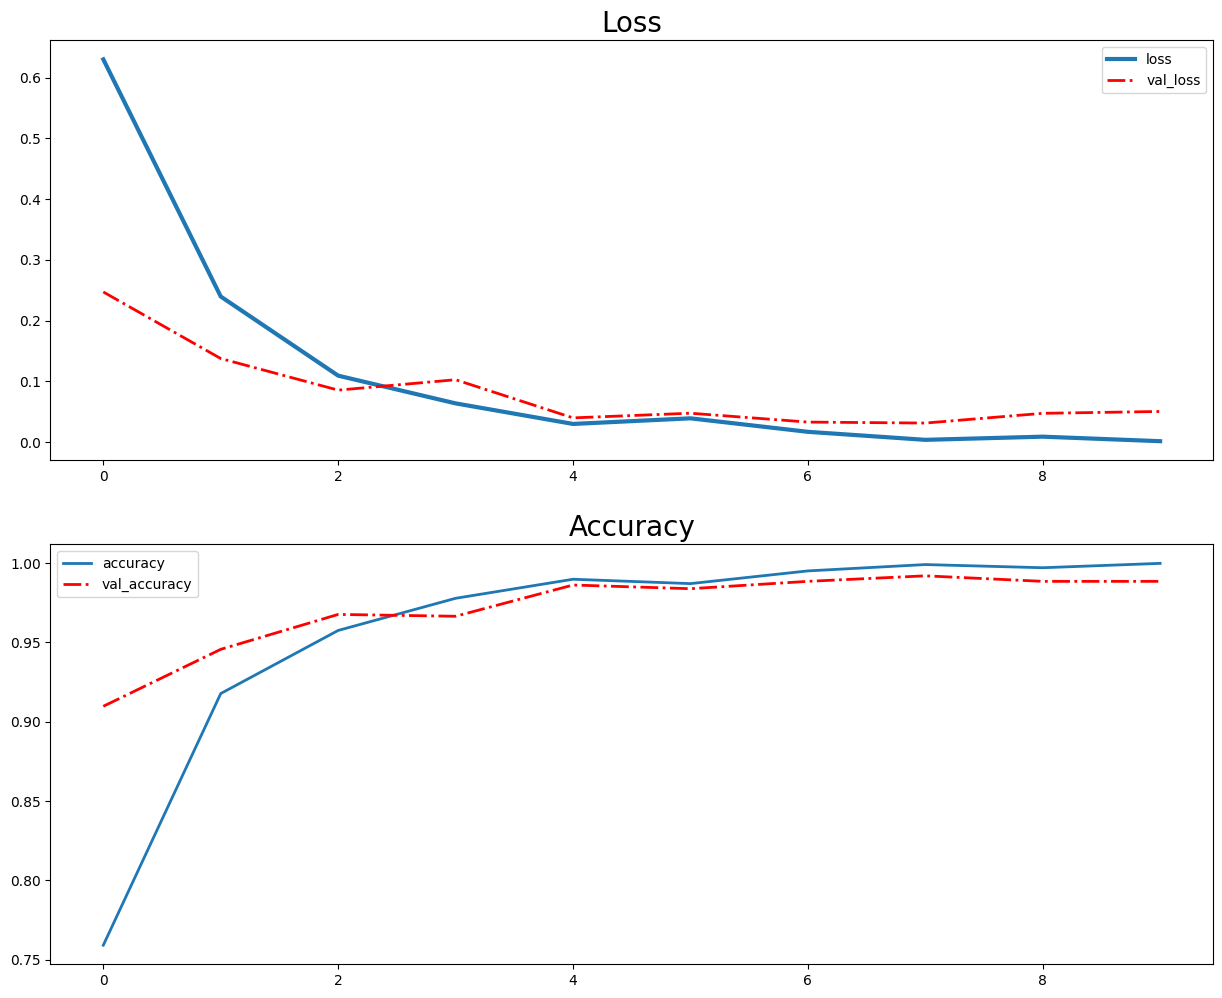

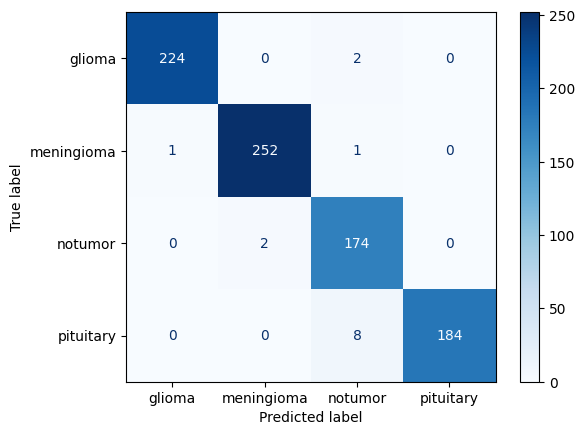

Classification Report
              precision    recall  f1-score   support

           0    0.99556   0.99115   0.99335       226
           1    0.99213   0.99213   0.99213       254
           2    0.94054   0.98864   0.96399       176
           3    1.00000   0.95833   0.97872       192

    accuracy                        0.98349       848
   macro avg    0.98206   0.98256   0.98205       848
weighted avg    0.98412   0.98349   0.98358       848



In [52]:
history_std_b0_tf25, test_loss, test_acc, test_f1score = plot(std_b0_tf25, history_std_b0_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-12 13:05:27.867574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 1.0211 - accuracy: 0.5563 - f1_score: 0.5406

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 16s 77ms/step - loss: 1.0139 - accuracy: 0.5606 - f1_score: 0.5451 - val_loss: 0.5068 - val_accuracy: 0.8147 - val_f1_score: 0.8190 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 4s 55ms/step - loss: 0.5109 - accuracy: 0.8050 - f1_score: 0.8107 - val_loss: 0.3114 - val_accuracy: 0.9040 - val_f1_score: 0.9044 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 3s 45ms/step - loss: 0.3272 - accuracy: 0.8820 - f1_score: 0.8886 - val_loss: 0.3174 - val_accuracy: 0.8951 - val_f1_score: 0.9049 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 4s 52ms/step - loss: 0.2488 - accuracy: 0.9156 - f1_score: 0.9209 - val_loss: 0.1839 - val_accuracy: 0.9420 - val_f1_score: 0.9427 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 3s 42ms/step - loss: 0.1458 - accuracy: 0.9520 - f1_score: 0.9563 - val_loss: 0.2346 - val_accuracy: 0.9353 - val_f1_score: 0.9371 - lr: 1.0000e-04
Epoch 6/10

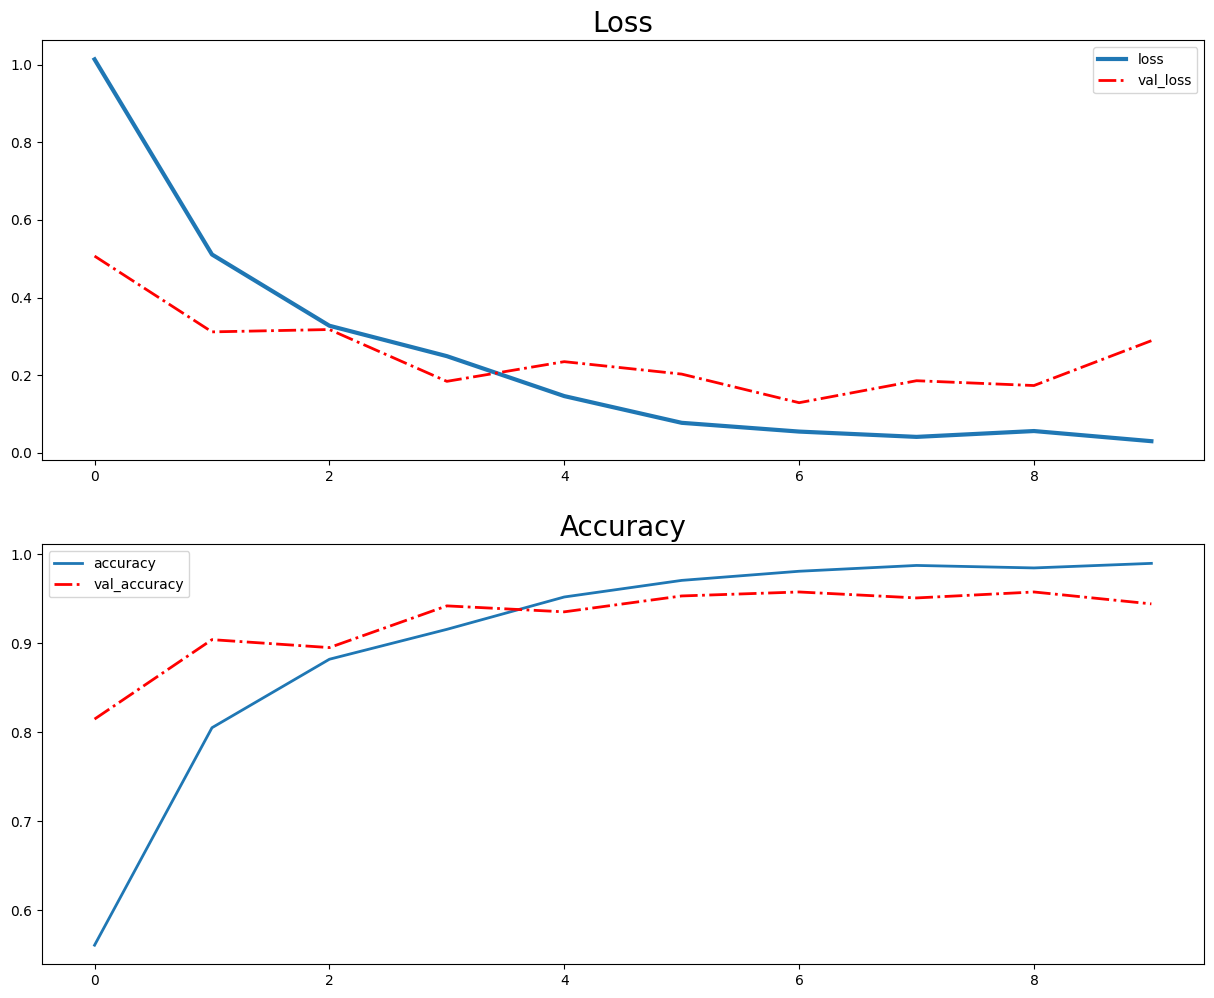

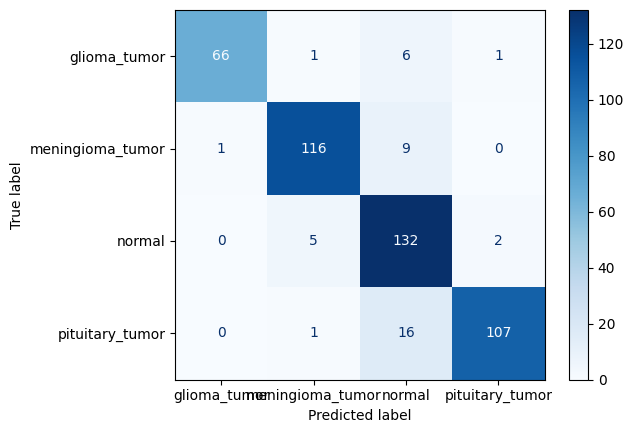

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.89      0.94        74
           1       0.94      0.92      0.93       126
           2       0.81      0.95      0.87       139
           3       0.97      0.86      0.91       124

    accuracy                           0.91       463
   macro avg       0.93      0.91      0.91       463
weighted avg       0.92      0.91      0.91       463



In [28]:
model_name = 'efficientnetv2b0_standart_trainable_last25'
input_shape = (224,224,3)

std_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl25, history_std_b0_tl25 = train(std_b0_tl25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b0_tl25, test_loss, test_acc, test_f1score = plot(std_b0_tl25, history_std_b0_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.2610 - accuracy: 0.4104 - f1_score: 0.3799

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 9s 59ms/step - loss: 1.2610 - accuracy: 0.4104 - f1_score: 0.3799 - val_loss: 1.0431 - val_accuracy: 0.6406 - val_f1_score: 0.6309 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 3s 37ms/step - loss: 0.9857 - accuracy: 0.6096 - f1_score: 0.6059 - val_loss: 0.7398 - val_accuracy: 0.7522 - val_f1_score: 0.7523 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 3s 37ms/step - loss: 0.8034 - accuracy: 0.6810 - f1_score: 0.6839 - val_loss: 0.6010 - val_accuracy: 0.7991 - val_f1_score: 0.8008 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 3s 43ms/step - loss: 0.6772 - accuracy: 0.7421 - f1_score: 0.7458 - val_loss: 0.5157 - val_accuracy: 0.8326 - val_f1_score: 0.8358 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 2s 36ms/step - loss: 0.5995 - accuracy: 0.7789 - f1_score: 0.7821 - val_loss: 0.4726 - val_accuracy: 0.8482 - val_f1_score: 0.8476 - lr: 1.0000e-04
Epoch 6/10


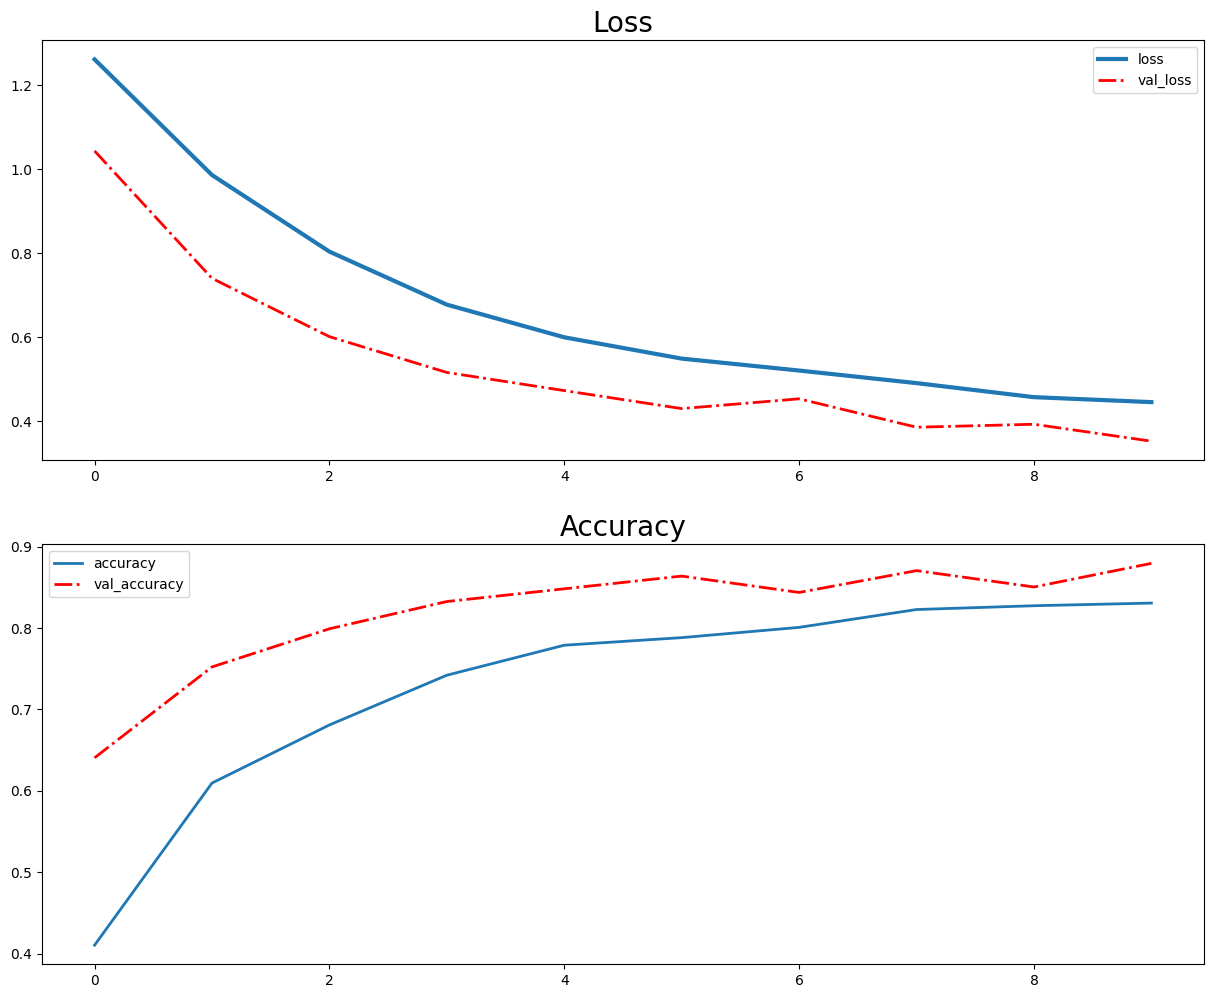

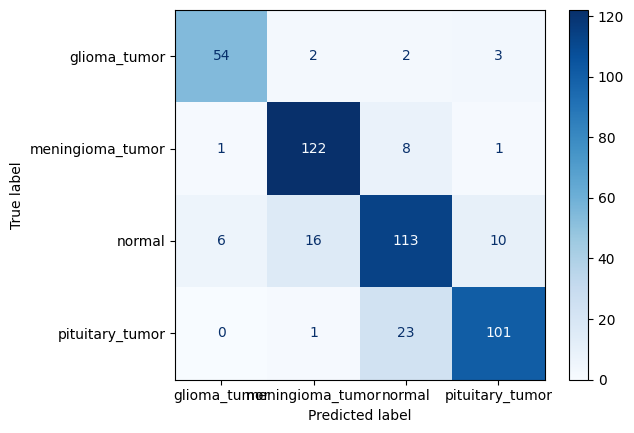

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        61
           1       0.87      0.92      0.89       132
           2       0.77      0.78      0.78       145
           3       0.88      0.81      0.84       125

    accuracy                           0.84       463
   macro avg       0.85      0.85      0.85       463
weighted avg       0.84      0.84      0.84       463



In [29]:
model_name = 'efficientnetv2b0_standart_not_trainable'
input_shape = (224,224,3)

std_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_nt, history_std_b0_nt = train(std_b0_nt, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b0_nt, test_loss, test_acc, test_f1score = plot(std_b0_nt, history_std_b0_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2B3

#### trainable first25

Epoch 1/10


2024-10-12 13:10:51.989309: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 48s 159ms/step - loss: 0.9937 - accuracy: 0.5751 - f1_score: 0.5675 - val_loss: 0.4407 - val_accuracy: 0.8683 - val_f1_score: 0.8690 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 9s 128ms/step - loss: 0.4487 - accuracy: 0.8382 - f1_score: 0.8442 - val_loss: 0.2314 - val_accuracy: 0.9286 - val_f1_score: 0.9274 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 9s 136ms/step - loss: 0.2249 - accuracy: 0.9184 - f1_score: 0.9231 - val_loss: 0.1385 - val_accuracy: 0.9554 - val_f1_score: 0.9579 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 9s 127ms/step - loss: 0.1269 - accuracy: 0.9566 - f1_score: 0.9606 - val_loss: 0.1481 - val_accuracy: 0.9598 - val_f1_score: 0.9620 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 9s 126ms/step - loss: 0.0783 - accuracy: 0.9739 - f1_score: 0.9766 - val_loss: 0.1098 - val_accuracy: 0.9710 - val_f1_score: 0.9733 - lr: 1.0000e-04
Epoch

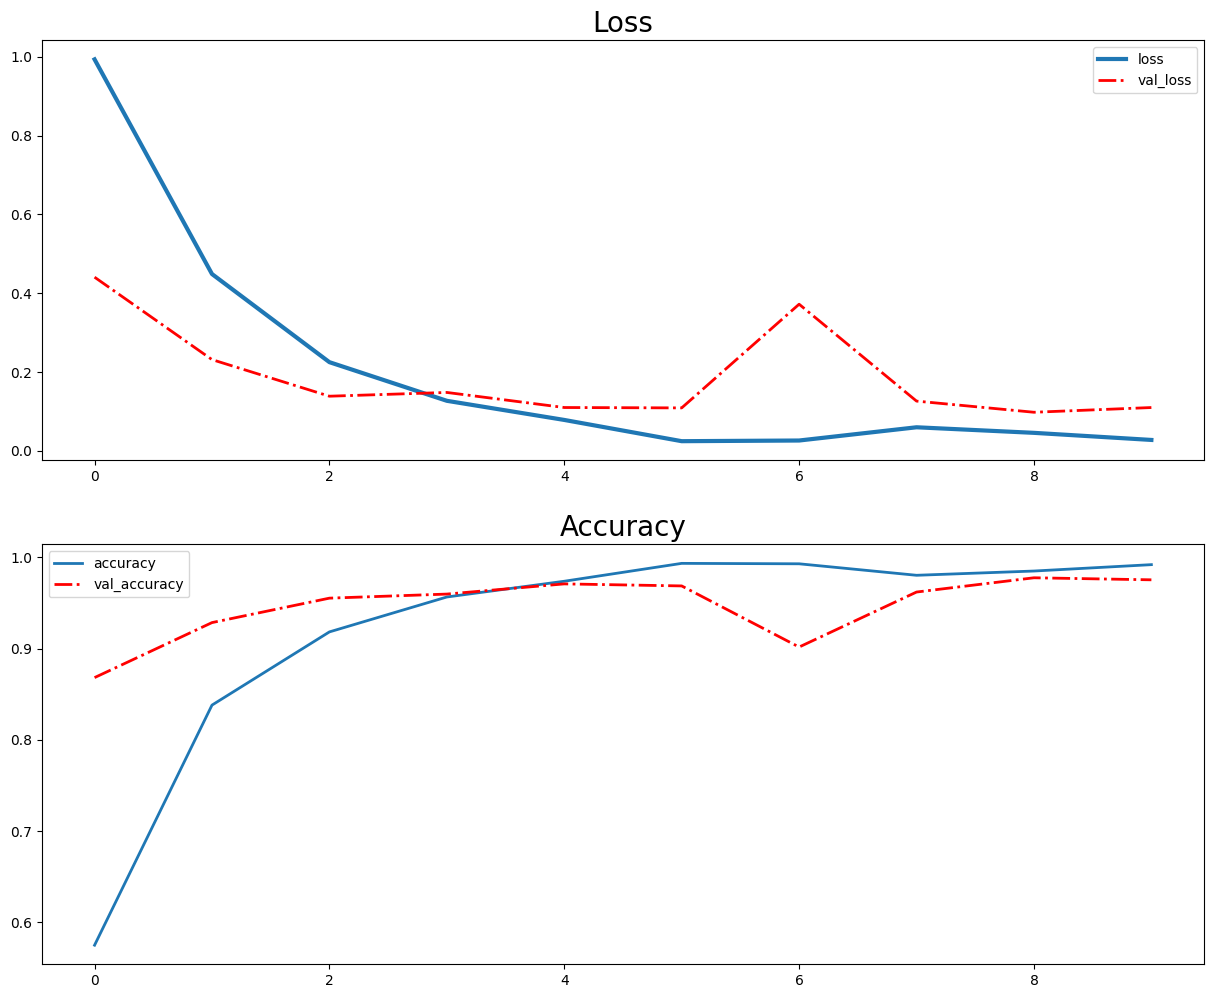

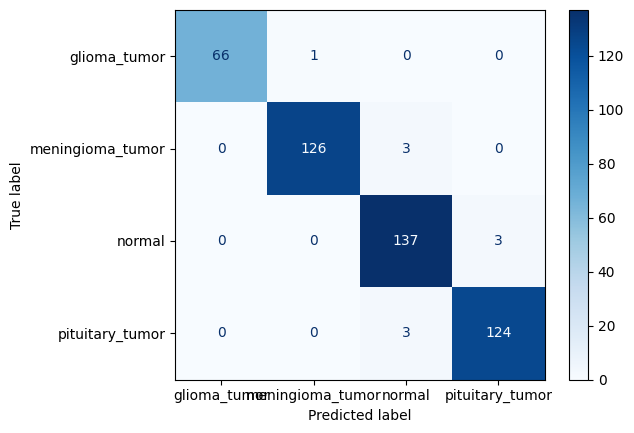

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       0.99      0.98      0.98       129
           2       0.96      0.98      0.97       140
           3       0.98      0.98      0.98       127

    accuracy                           0.98       463
   macro avg       0.98      0.98      0.98       463
weighted avg       0.98      0.98      0.98       463



In [33]:
model_name = 'efficientnetv2b3_standart_trainable_first25'
input_shape = (224,224,3)

std_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf25, history_std_b3_tf25 = train(std_b3_tf25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b3_tf25, test_loss, test_acc, test_f1score = plot(std_b3_tf25, history_std_b3_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-12 13:13:25.755791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.9445 - accuracy: 0.5951 - f1_score: 0.5809

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 24s 106ms/step - loss: 0.9445 - accuracy: 0.5951 - f1_score: 0.5809 - val_loss: 0.4046 - val_accuracy: 0.8616 - val_f1_score: 0.8686 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 5s 72ms/step - loss: 0.3979 - accuracy: 0.8517 - f1_score: 0.8549 - val_loss: 0.2690 - val_accuracy: 0.8996 - val_f1_score: 0.9044 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 5s 76ms/step - loss: 0.2368 - accuracy: 0.9174 - f1_score: 0.9240 - val_loss: 0.2487 - val_accuracy: 0.9263 - val_f1_score: 0.9286 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 4s 55ms/step - loss: 0.1247 - accuracy: 0.9585 - f1_score: 0.9624 - val_loss: 0.2256 - val_accuracy: 0.9308 - val_f1_score: 0.9341 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 4s 60ms/step - loss: 0.0743 - accuracy: 0.9739 - f1_score: 0.9763 - val_loss: 0.2242 - val_accuracy: 0.9353 - val_f1_score: 0.9388 - lr: 1.0000e-04
Epoch 6/1

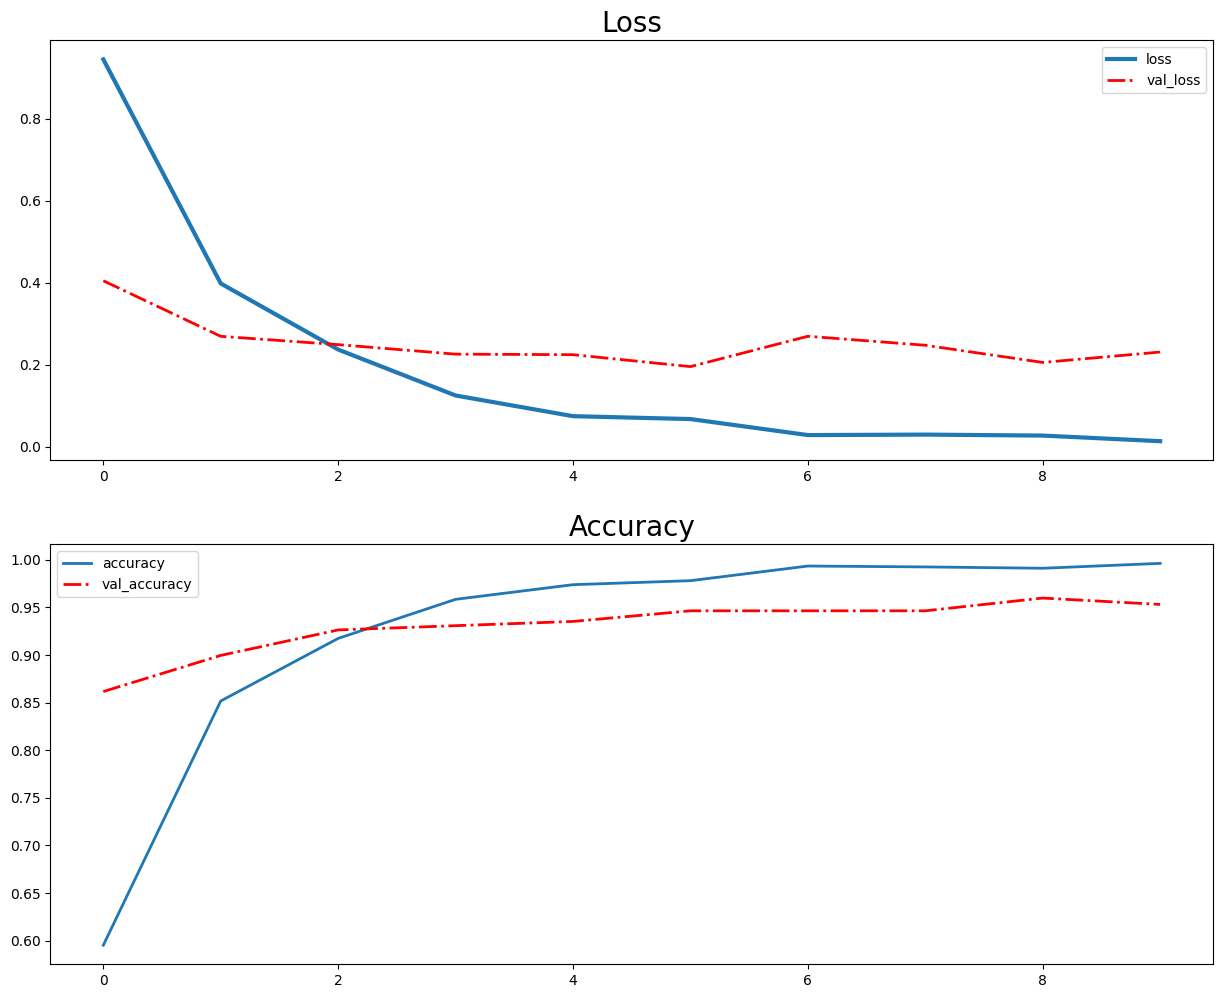

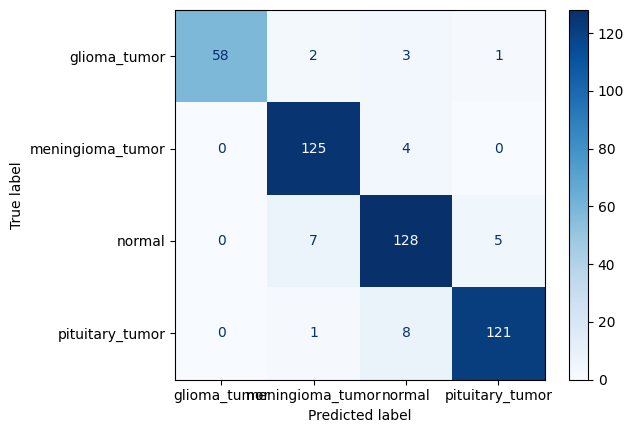

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        64
           1       0.93      0.97      0.95       129
           2       0.90      0.91      0.90       140
           3       0.95      0.93      0.94       130

    accuracy                           0.93       463
   macro avg       0.94      0.93      0.94       463
weighted avg       0.93      0.93      0.93       463



In [34]:
model_name = 'efficientnetv2b3_standart_trainable_last25'
input_shape = (224,224,3)

std_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl25, history_std_b3_tl25 = train(std_b3_tl25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b3_tl25, test_loss, test_acc, test_f1score = plot(std_b3_tl25, history_std_b3_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.2427 - accuracy: 0.4216 - f1_score: 0.4057

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 13s 82ms/step - loss: 1.2427 - accuracy: 0.4216 - f1_score: 0.4057 - val_loss: 0.9514 - val_accuracy: 0.7277 - val_f1_score: 0.7304 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 4s 55ms/step - loss: 0.9255 - accuracy: 0.6469 - f1_score: 0.6522 - val_loss: 0.6613 - val_accuracy: 0.8125 - val_f1_score: 0.8163 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 3s 40ms/step - loss: 0.7610 - accuracy: 0.7192 - f1_score: 0.7258 - val_loss: 0.5839 - val_accuracy: 0.8125 - val_f1_score: 0.8197 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 3s 50ms/step - loss: 0.6668 - accuracy: 0.7411 - f1_score: 0.7474 - val_loss: 0.4851 - val_accuracy: 0.8371 - val_f1_score: 0.8491 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 3s 49ms/step - loss: 0.5824 - accuracy: 0.7854 - f1_score: 0.7937 - val_loss: 0.4204 - val_accuracy: 0.8549 - val_f1_score: 0.8634 - lr: 1.0000e-04
Epoch 6/10

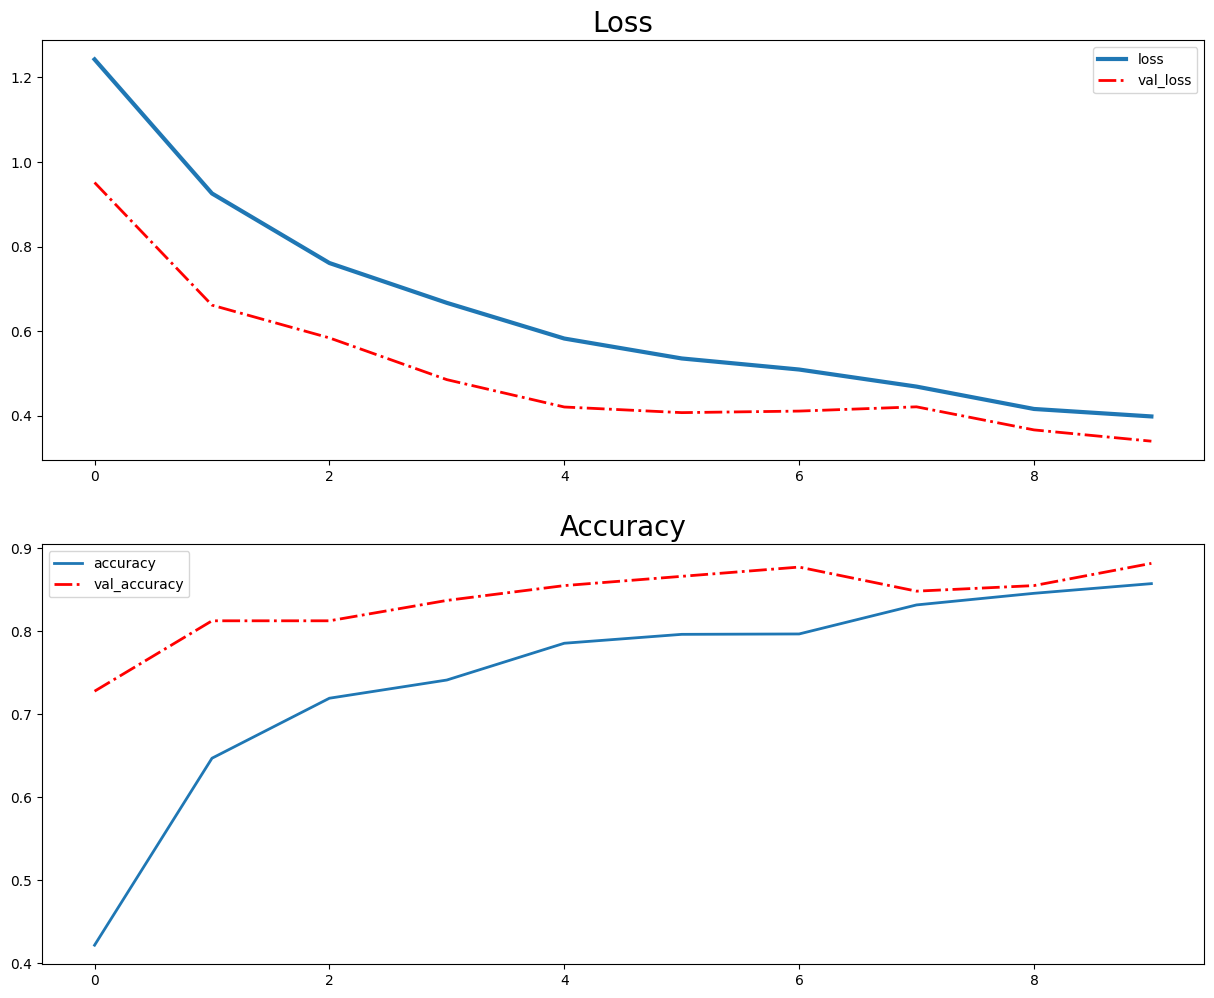

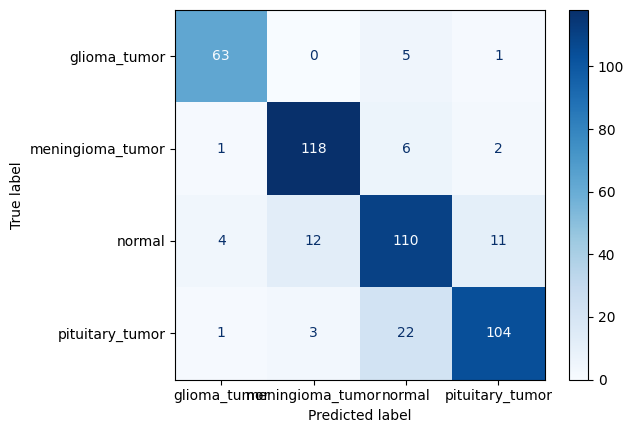

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        69
           1       0.89      0.93      0.91       127
           2       0.77      0.80      0.79       137
           3       0.88      0.80      0.84       130

    accuracy                           0.85       463
   macro avg       0.86      0.86      0.86       463
weighted avg       0.85      0.85      0.85       463



In [36]:
model_name = 'efficientnetv2b3_standart_not_trainable'
input_shape = (224,224,3)

std_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_nt, history_std_b3_nt = train(std_b3_nt, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b3_nt, test_loss, test_acc, test_f1score = plot(std_b3_nt, history_std_b3_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2M

#### trainable first25

214201816/214201816 [==============================] - 10s 0us/step
Epoch 1/10


2024-10-12 13:18:03.761439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 1.0214 - accuracy: 0.5485 - f1_score: 0.5361

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 91s 257ms/step - loss: 1.0214 - accuracy: 0.5485 - f1_score: 0.5361 - val_loss: 0.7840 - val_accuracy: 0.7121 - val_f1_score: 0.7017 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 13s 193ms/step - loss: 0.3988 - accuracy: 0.8601 - f1_score: 0.8646 - val_loss: 0.1830 - val_accuracy: 0.9420 - val_f1_score: 0.9393 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 13s 201ms/step - loss: 0.1618 - accuracy: 0.9492 - f1_score: 0.9516 - val_loss: 0.1294 - val_accuracy: 0.9598 - val_f1_score: 0.9595 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 13s 196ms/step - loss: 0.0669 - accuracy: 0.9799 - f1_score: 0.9808 - val_loss: 0.0759 - val_accuracy: 0.9777 - val_f1_score: 0.9766 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 11s 157ms/step - loss: 0.1307 - accuracy: 0.9590 - f1_score: 0.9620 - val_loss: 0.1568 - val_accuracy: 0.9554 - val_f1_score: 0.9560 - lr: 1.0000e-04
E

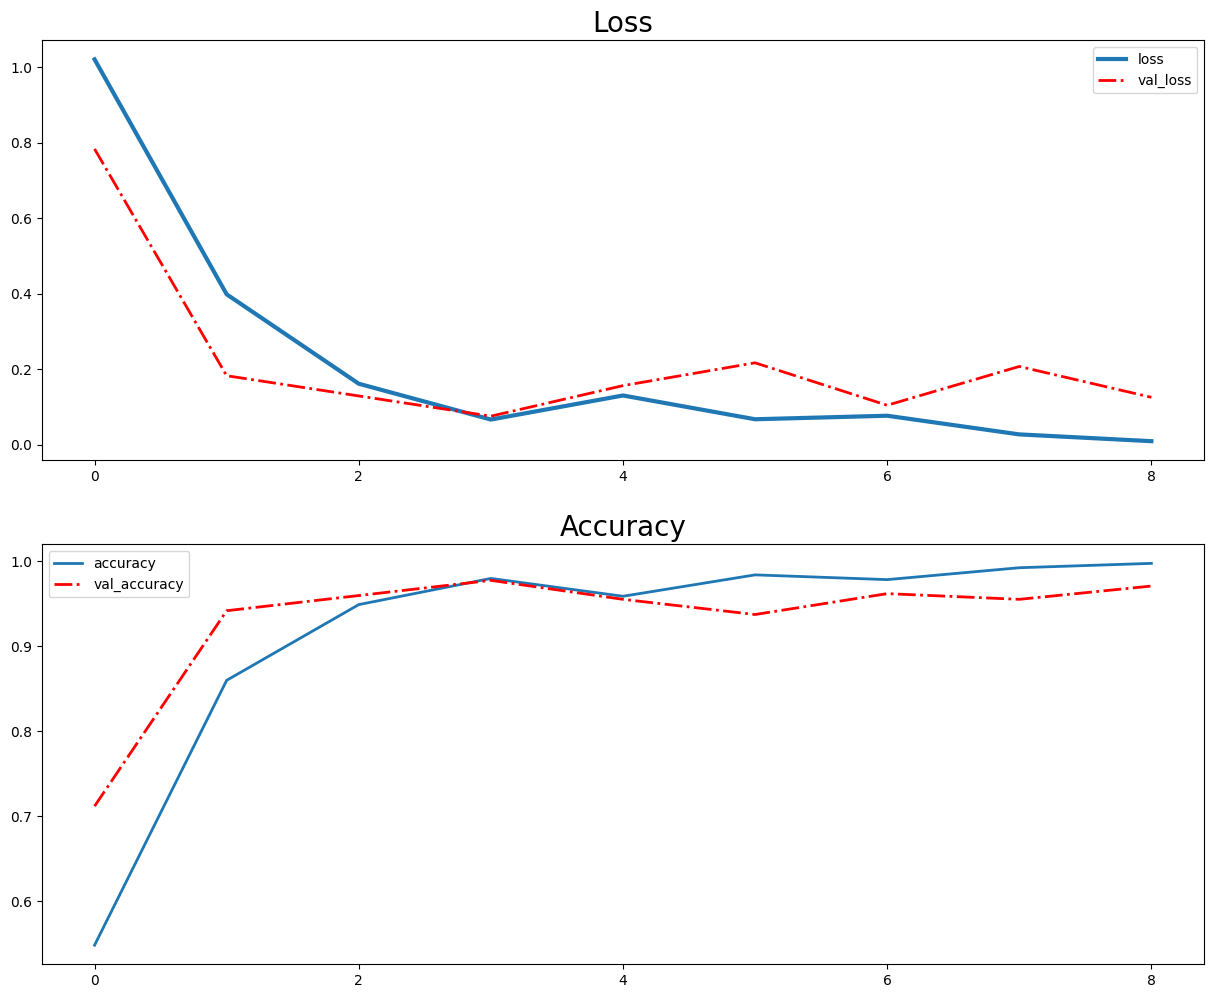

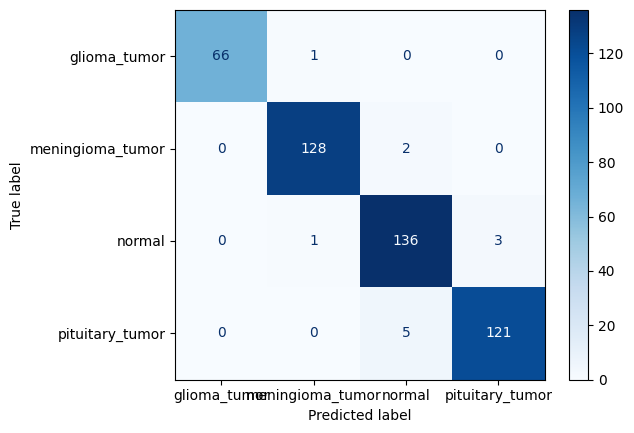

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       0.98      0.98      0.98       130
           2       0.95      0.97      0.96       140
           3       0.98      0.96      0.97       126

    accuracy                           0.97       463
   macro avg       0.98      0.98      0.98       463
weighted avg       0.97      0.97      0.97       463



In [37]:
model_name = 'efficientnetv2m_standart_trainable_first25'
input_shape = (224,224,3)

std_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf25, history_std_m_tf25 = train(std_m_tf25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_m_tf25, test_loss, test_acc, test_f1score = plot(std_m_tf25, history_std_m_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-12 13:21:09.004846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.6898 - f1_score: 0.6924

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 46s 220ms/step - loss: 0.7562 - accuracy: 0.6898 - f1_score: 0.6924 - val_loss: 0.3568 - val_accuracy: 0.8683 - val_f1_score: 0.8707 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 9s 134ms/step - loss: 0.3152 - accuracy: 0.8918 - f1_score: 0.8975 - val_loss: 0.2171 - val_accuracy: 0.9286 - val_f1_score: 0.9299 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 7s 98ms/step - loss: 0.1665 - accuracy: 0.9445 - f1_score: 0.9494 - val_loss: 0.2229 - val_accuracy: 0.9174 - val_f1_score: 0.9216 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 7s 98ms/step - loss: 0.1599 - accuracy: 0.9454 - f1_score: 0.9486 - val_loss: 0.2345 - val_accuracy: 0.9174 - val_f1_score: 0.9229 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 9s 138ms/step - loss: 0.0682 - accuracy: 0.9762 - f1_score: 0.9788 - val_loss: 0.1475 - val_accuracy: 0.9554 - val_f1_score: 0.9553 - lr: 1.0000e-04
Epoch 6

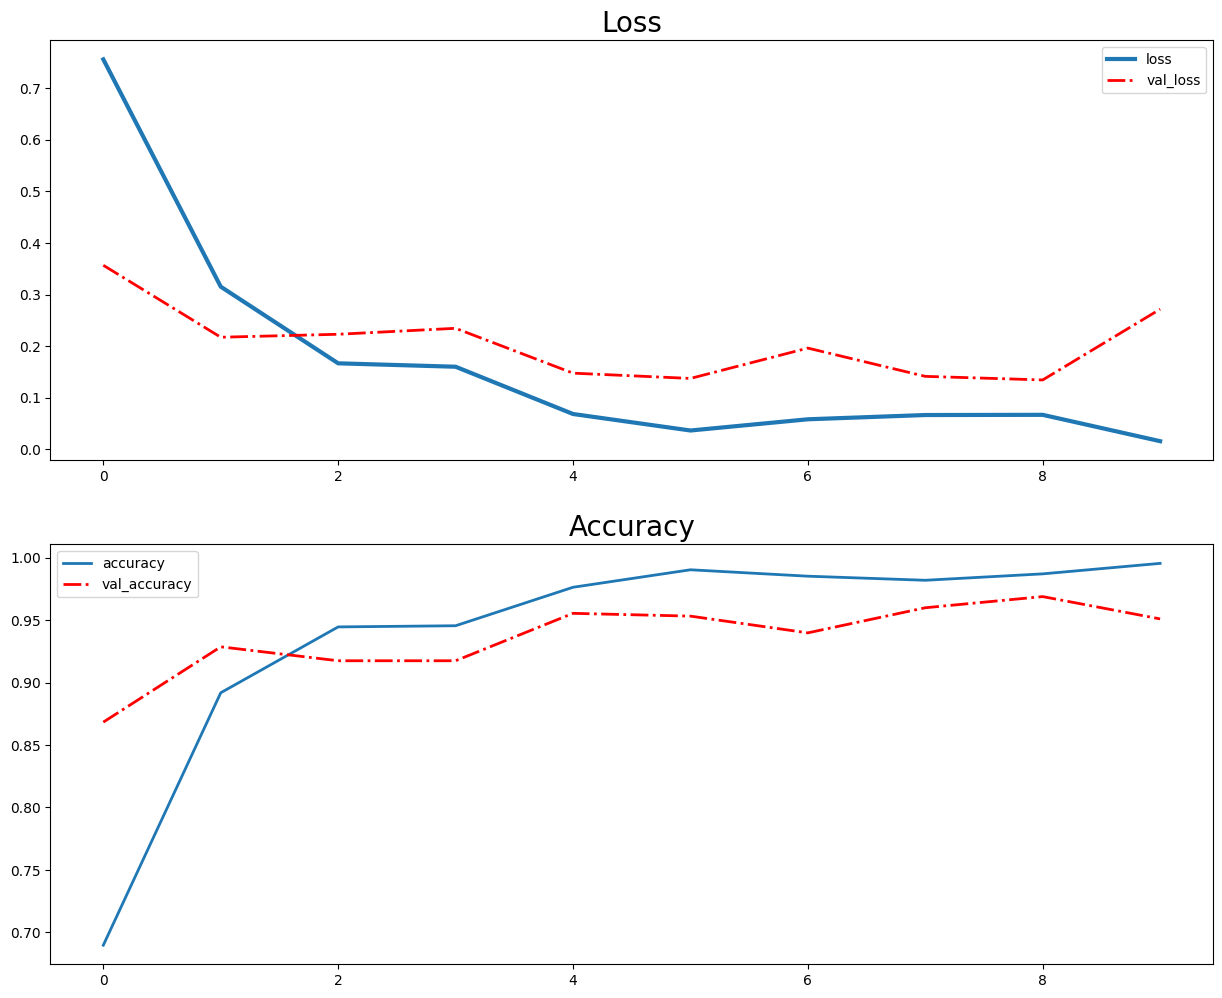

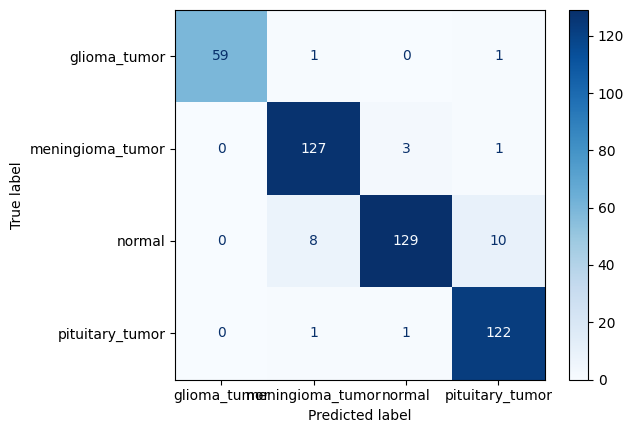

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        61
           1       0.93      0.97      0.95       131
           2       0.97      0.88      0.92       147
           3       0.91      0.98      0.95       124

    accuracy                           0.94       463
   macro avg       0.95      0.95      0.95       463
weighted avg       0.95      0.94      0.94       463



In [38]:
model_name = 'efficientnetv2m_standart_trainable_last25'
input_shape = (224,224,3)

std_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl25, history_std_m_tl25 = train(std_m_tl25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_m_tl25, test_loss, test_acc, test_f1score = plot(std_m_tl25, history_std_m_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.2711 - accuracy: 0.3811 - f1_score: 0.3246

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 31s 214ms/step - loss: 1.2711 - accuracy: 0.3811 - f1_score: 0.3246 - val_loss: 1.0621 - val_accuracy: 0.6004 - val_f1_score: 0.5277 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 9s 138ms/step - loss: 1.0185 - accuracy: 0.5821 - f1_score: 0.5582 - val_loss: 0.8353 - val_accuracy: 0.7165 - val_f1_score: 0.7267 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 10s 145ms/step - loss: 0.8688 - accuracy: 0.6581 - f1_score: 0.6544 - val_loss: 0.7301 - val_accuracy: 0.7455 - val_f1_score: 0.7517 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 9s 139ms/step - loss: 0.7592 - accuracy: 0.7038 - f1_score: 0.7047 - val_loss: 0.6160 - val_accuracy: 0.7723 - val_f1_score: 0.7748 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 10s 153ms/step - loss: 0.6848 - accuracy: 0.7430 - f1_score: 0.7471 - val_loss: 0.5584 - val_accuracy: 0.8214 - val_f1_score: 0.8193 - lr: 1.0000e-04
Epo

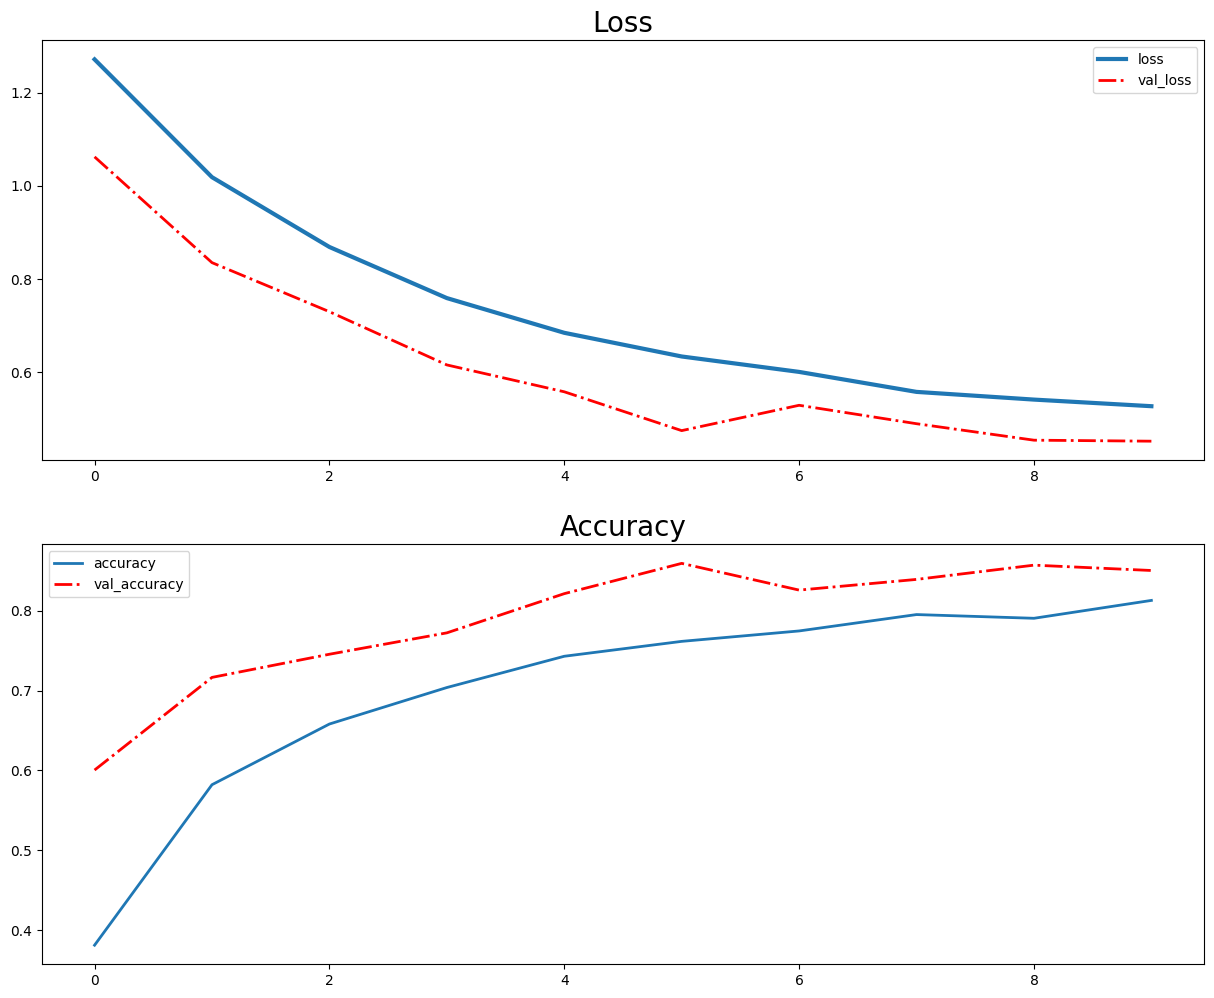

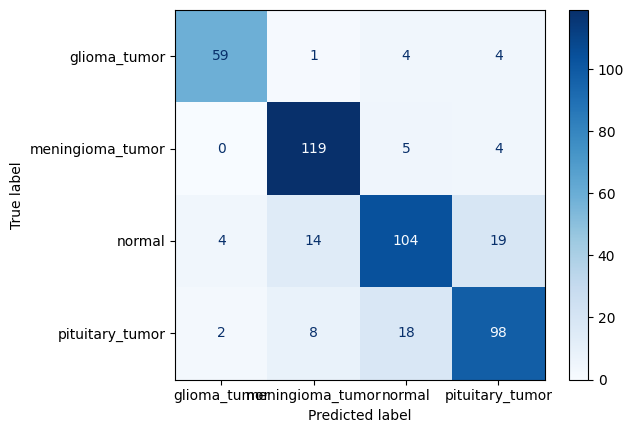

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        68
           1       0.84      0.93      0.88       128
           2       0.79      0.74      0.76       141
           3       0.78      0.78      0.78       126

    accuracy                           0.82       463
   macro avg       0.83      0.83      0.83       463
weighted avg       0.82      0.82      0.82       463



In [39]:
model_name = 'efficientnetv2m_standart_not_trainable'
input_shape = (224,224,3)

std_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_nt, history_std_m_nt = train(std_m_nt, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_m_nt, test_loss, test_acc, test_f1score = plot(std_m_nt, history_std_m_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

## Augmentation

In [40]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomTranslation(0.15, 0.15)
])

In [41]:
def augmentation_train(image, label):
    image = preprocess_input(image)
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = preprocess_input(image)
    return image, label

In [42]:
train_aug = train_ds.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
train_aug = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### EfficientNetV2B0

#### trainable first25

Epoch 1/10


2024-10-12 13:27:03.805531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.9942 - accuracy: 0.5676 - f1_score: 0.5508

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 42s 209ms/step - loss: 0.9942 - accuracy: 0.5676 - f1_score: 0.5508 - val_loss: 0.4537 - val_accuracy: 0.8594 - val_f1_score: 0.8536 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 6s 85ms/step - loss: 0.5233 - accuracy: 0.8083 - f1_score: 0.8140 - val_loss: 0.3087 - val_accuracy: 0.8951 - val_f1_score: 0.9067 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 5s 75ms/step - loss: 0.3102 - accuracy: 0.8899 - f1_score: 0.8944 - val_loss: 0.2805 - val_accuracy: 0.9152 - val_f1_score: 0.9204 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 5s 73ms/step - loss: 0.2062 - accuracy: 0.9300 - f1_score: 0.9351 - val_loss: 0.1701 - val_accuracy: 0.9420 - val_f1_score: 0.9456 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 5s 82ms/step - loss: 0.1050 - accuracy: 0.9678 - f1_score: 0.9699 - val_loss: 0.1325 - val_accuracy: 0.9554 - val_f1_score: 0.9600 - lr: 1.0000e-04
Epoch 6/1

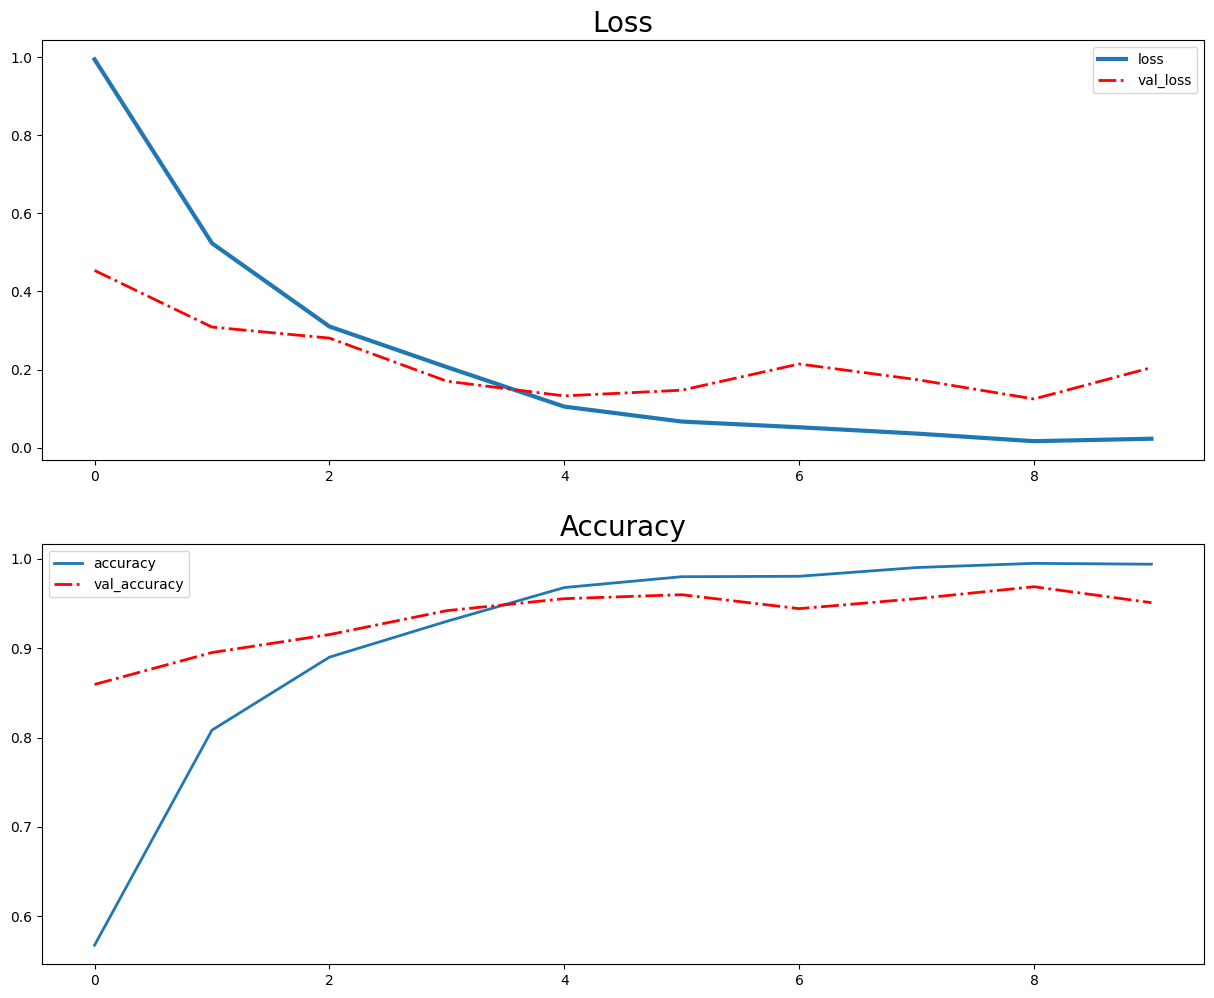

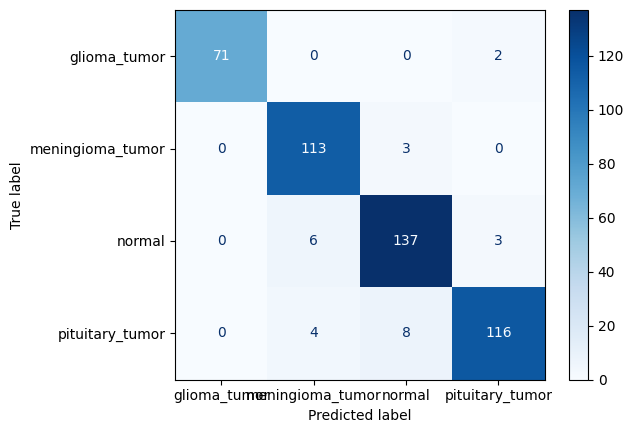

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        73
           1       0.92      0.97      0.95       116
           2       0.93      0.94      0.93       146
           3       0.96      0.91      0.93       128

    accuracy                           0.94       463
   macro avg       0.95      0.95      0.95       463
weighted avg       0.94      0.94      0.94       463



In [44]:
model_name = 'efficientnetv2b0_augmentation_trainable_first25'
input_shape = (224,224,3)

aug_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tf25, history_aug_b0_tf25 = train(aug_b0_tf25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_tf25, test_loss, test_acc, test_f1score = plot(aug_b0_tf25, history_aug_b0_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-12 13:28:46.975287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 1.0699 - accuracy: 0.5201 - f1_score: 0.5165

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 17s 78ms/step - loss: 1.0699 - accuracy: 0.5201 - f1_score: 0.5165 - val_loss: 0.5299 - val_accuracy: 0.8214 - val_f1_score: 0.8244 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 3s 46ms/step - loss: 0.5093 - accuracy: 0.8064 - f1_score: 0.8137 - val_loss: 0.3636 - val_accuracy: 0.8705 - val_f1_score: 0.8727 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 3s 46ms/step - loss: 0.3207 - accuracy: 0.8853 - f1_score: 0.8914 - val_loss: 0.2428 - val_accuracy: 0.9174 - val_f1_score: 0.9206 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 3s 45ms/step - loss: 0.1945 - accuracy: 0.9291 - f1_score: 0.9343 - val_loss: 0.2473 - val_accuracy: 0.9219 - val_f1_score: 0.9259 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 2s 37ms/step - loss: 0.1324 - accuracy: 0.9501 - f1_score: 0.9552 - val_loss: 0.2605 - val_accuracy: 0.9196 - val_f1_score: 0.9248 - lr: 1.0000e-04
Epoch 6/10

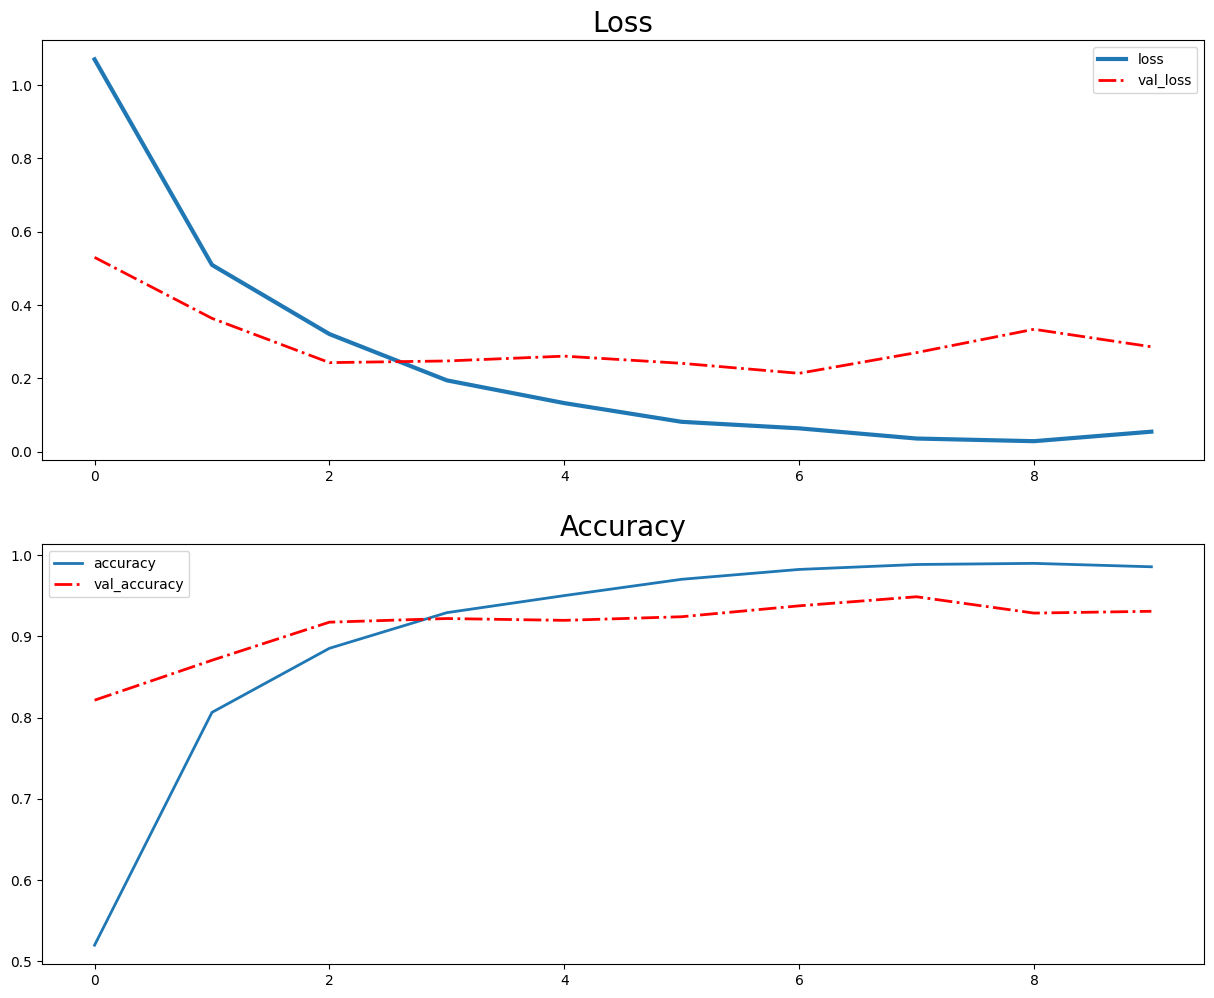

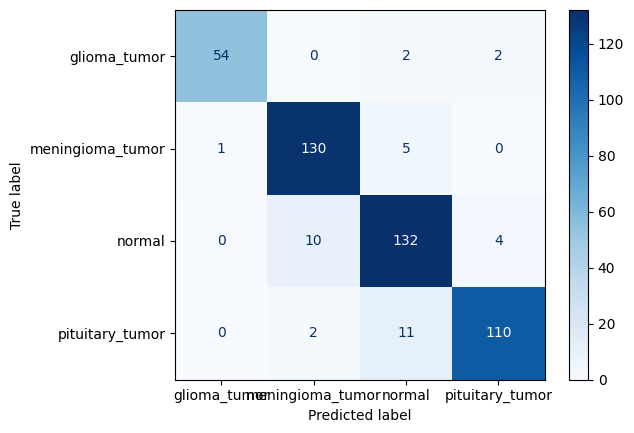

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        58
           1       0.92      0.96      0.94       136
           2       0.88      0.90      0.89       146
           3       0.95      0.89      0.92       123

    accuracy                           0.92       463
   macro avg       0.93      0.92      0.93       463
weighted avg       0.92      0.92      0.92       463



In [45]:
model_name = 'efficientnetv2b0_augmentation_trainable_last25'
input_shape = (224,224,3)

aug_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tl25, history_aug_b0_tl25 = train(aug_b0_tl25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_tl25, test_loss, test_acc, test_f1score = plot(aug_b0_tl25, history_aug_b0_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
66/67 [============================>.] - ETA: 0s - loss: 1.2537 - accuracy: 0.4323 - f1_score: 0.3804

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 9s 59ms/step - loss: 1.2479 - accuracy: 0.4375 - f1_score: 0.3842 - val_loss: 0.9909 - val_accuracy: 0.6830 - val_f1_score: 0.6494 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 2s 31ms/step - loss: 0.9712 - accuracy: 0.6222 - f1_score: 0.6094 - val_loss: 0.7387 - val_accuracy: 0.7545 - val_f1_score: 0.7491 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 2s 30ms/step - loss: 0.7738 - accuracy: 0.7034 - f1_score: 0.7043 - val_loss: 0.5950 - val_accuracy: 0.7924 - val_f1_score: 0.7959 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 2s 30ms/step - loss: 0.6773 - accuracy: 0.7435 - f1_score: 0.7453 - val_loss: 0.5142 - val_accuracy: 0.8326 - val_f1_score: 0.8331 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 2s 24ms/step - loss: 0.6215 - accuracy: 0.7603 - f1_score: 0.7620 - val_loss: 0.4754 - val_accuracy: 0.8192 - val_f1_score: 0.8221 - lr: 1.0000e-04
Epoch 6/10


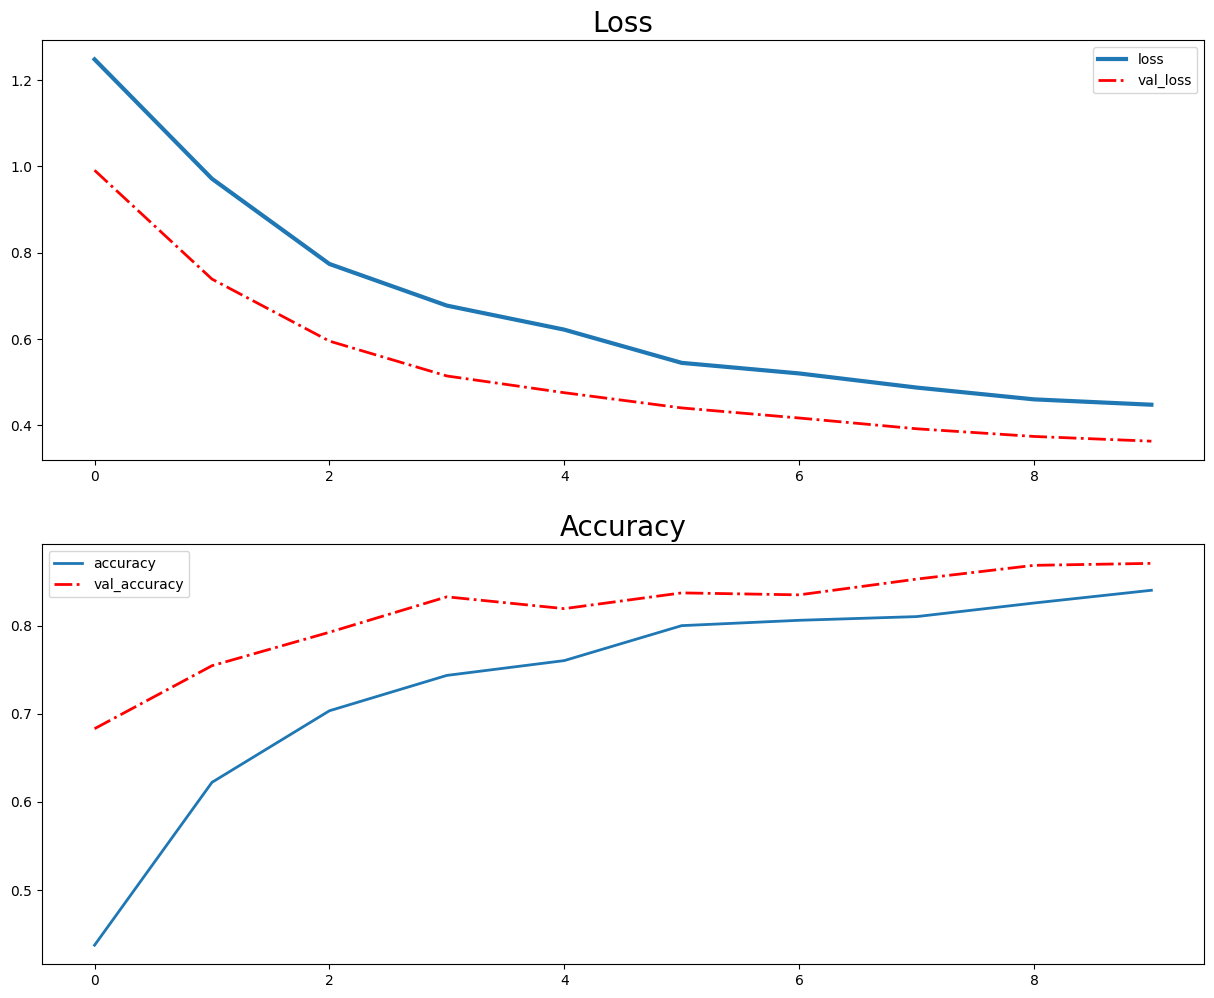

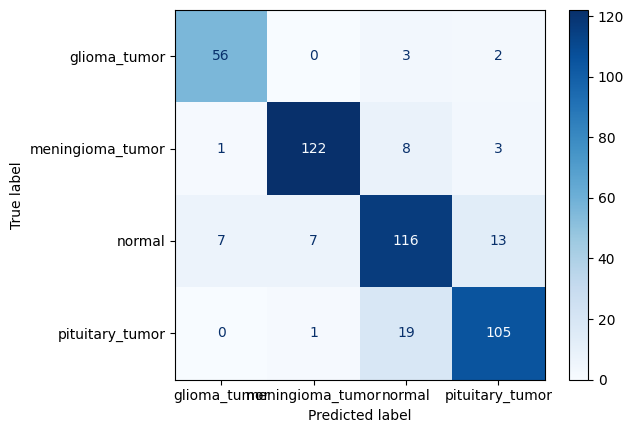

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        61
           1       0.94      0.91      0.92       134
           2       0.79      0.81      0.80       143
           3       0.85      0.84      0.85       125

    accuracy                           0.86       463
   macro avg       0.87      0.87      0.87       463
weighted avg       0.86      0.86      0.86       463



In [46]:
model_name = 'efficientnetv2b0_augmentation_not_trainable'
input_shape = (224,224,3)

aug_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_nt, history_aug_b0_nt = train(aug_b0_nt, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_nt, test_loss, test_acc, test_f1score = plot(aug_b0_nt, history_aug_b0_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2B3

#### trainable first25

Epoch 1/10


2024-10-12 13:34:57.755725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/dropout_38/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 50s 155ms/step - loss: 0.9754 - accuracy: 0.5849 - f1_score: 0.5777 - val_loss: 0.3761 - val_accuracy: 0.8817 - val_f1_score: 0.8853 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 8s 117ms/step - loss: 0.3647 - accuracy: 0.8722 - f1_score: 0.8748 - val_loss: 0.1938 - val_accuracy: 0.9531 - val_f1_score: 0.9566 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 8s 119ms/step - loss: 0.1786 - accuracy: 0.9412 - f1_score: 0.9452 - val_loss: 0.1359 - val_accuracy: 0.9554 - val_f1_score: 0.9579 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 6s 96ms/step - loss: 0.1237 - accuracy: 0.9650 - f1_score: 0.9672 - val_loss: 0.1570 - val_accuracy: 0.9554 - val_f1_score: 0.9585 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 8s 121ms/step - loss: 0.0497 - accuracy: 0.9837 - f1_score: 0.9854 - val_loss: 0.1316 - val_accuracy: 0.9754 - val_f1_score: 0.9777 - lr: 1.0000e-04
Epoch 

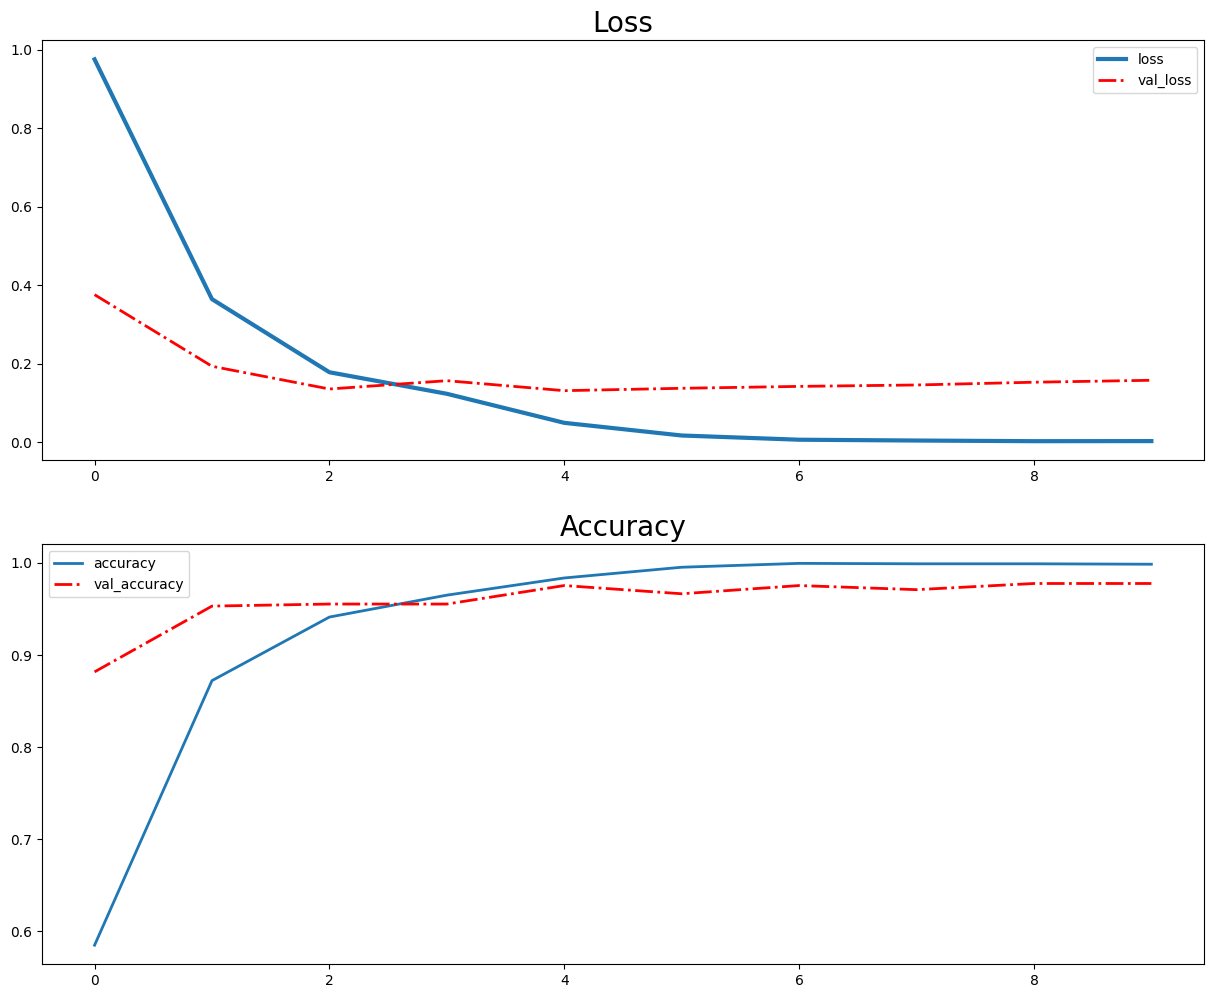

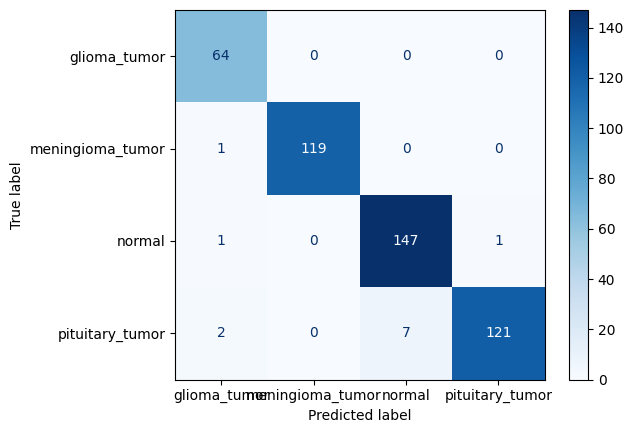

Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        64
           1       1.00      0.99      1.00       120
           2       0.95      0.99      0.97       149
           3       0.99      0.93      0.96       130

    accuracy                           0.97       463
   macro avg       0.97      0.98      0.97       463
weighted avg       0.97      0.97      0.97       463



In [48]:
model_name = 'efficientnetv2b3_augmentation_trainable_first25'
input_shape = (224,224,3)

aug_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tf25, history_aug_b3_tf25 = train(aug_b3_tf25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_tf25, test_loss, test_acc, test_f1score = plot(aug_b3_tf25, history_aug_b3_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-12 13:36:58.289155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.9196 - accuracy: 0.6091 - f1_score: 0.6011

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 23s 97ms/step - loss: 0.9196 - accuracy: 0.6091 - f1_score: 0.6011 - val_loss: 0.4150 - val_accuracy: 0.8527 - val_f1_score: 0.8575 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 4s 65ms/step - loss: 0.4132 - accuracy: 0.8498 - f1_score: 0.8548 - val_loss: 0.2410 - val_accuracy: 0.9085 - val_f1_score: 0.9108 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 4s 62ms/step - loss: 0.2053 - accuracy: 0.9277 - f1_score: 0.9320 - val_loss: 0.3311 - val_accuracy: 0.9129 - val_f1_score: 0.9183 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 4s 65ms/step - loss: 0.1177 - accuracy: 0.9608 - f1_score: 0.9649 - val_loss: 0.2080 - val_accuracy: 0.9420 - val_f1_score: 0.9456 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 4s 55ms/step - loss: 0.0497 - accuracy: 0.9851 - f1_score: 0.9866 - val_loss: 0.3314 - val_accuracy: 0.9241 - val_f1_score: 0.9312 - lr: 1.0000e-04
Epoch 6/10

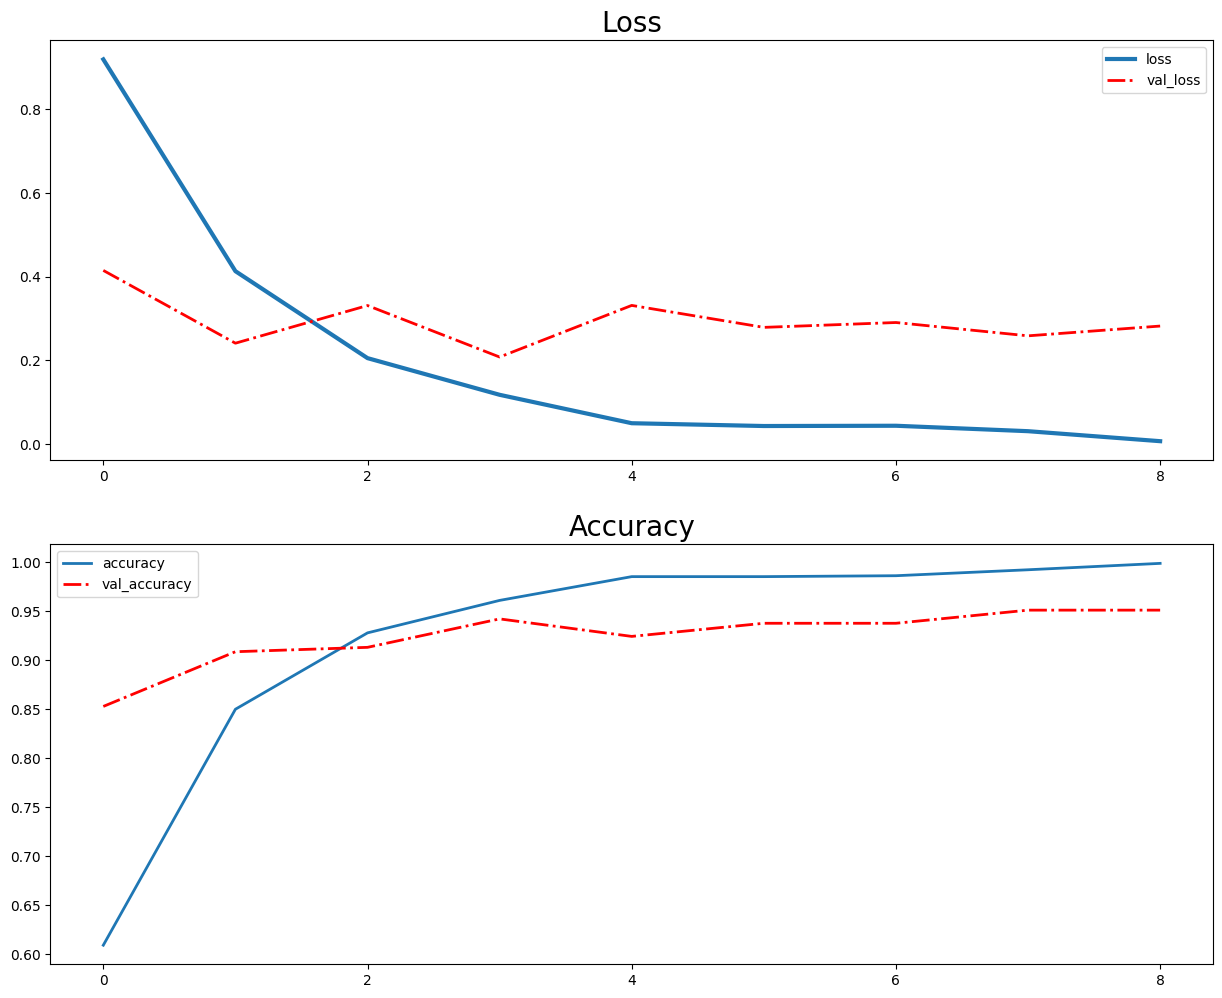

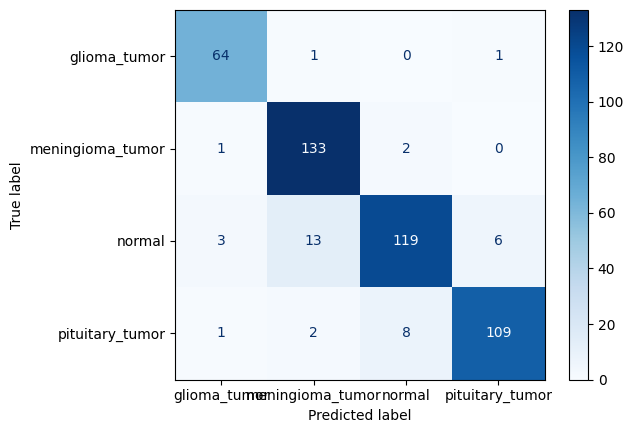

Classification Report
              precision    recall  f1-score   support

           0    0.92754   0.96970   0.94815        66
           1    0.89262   0.97794   0.93333       136
           2    0.92248   0.84397   0.88148       141
           3    0.93966   0.90833   0.92373       120

    accuracy                        0.91793       463
   macro avg    0.92057   0.92499   0.92167       463
weighted avg    0.91888   0.91793   0.91717       463



In [50]:
model_name = 'efficientnetv2m_augmentation_trainable_last25'
input_shape = (224,224,3)

aug_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tl25, history_aug_b3_tl25 = train(aug_b3_tl25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_tl25, test_loss, test_acc, test_f1score = plot(aug_b3_tl25, history_aug_b3_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
66/67 [============================>.] - ETA: 0s - loss: 1.2318 - accuracy: 0.4313 - f1_score: 0.3927

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 13s 74ms/step - loss: 1.2295 - accuracy: 0.4338 - f1_score: 0.3944 - val_loss: 0.9458 - val_accuracy: 0.7076 - val_f1_score: 0.7000 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 3s 44ms/step - loss: 0.9196 - accuracy: 0.6371 - f1_score: 0.6274 - val_loss: 0.6829 - val_accuracy: 0.7701 - val_f1_score: 0.7767 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 3s 42ms/step - loss: 0.7485 - accuracy: 0.7094 - f1_score: 0.7138 - val_loss: 0.5483 - val_accuracy: 0.8125 - val_f1_score: 0.8185 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 3s 42ms/step - loss: 0.6424 - accuracy: 0.7570 - f1_score: 0.7631 - val_loss: 0.4899 - val_accuracy: 0.8214 - val_f1_score: 0.8289 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 3s 42ms/step - loss: 0.5804 - accuracy: 0.7878 - f1_score: 0.7939 - val_loss: 0.4454 - val_accuracy: 0.8304 - val_f1_score: 0.8403 - lr: 1.0000e-04
Epoch 6/10

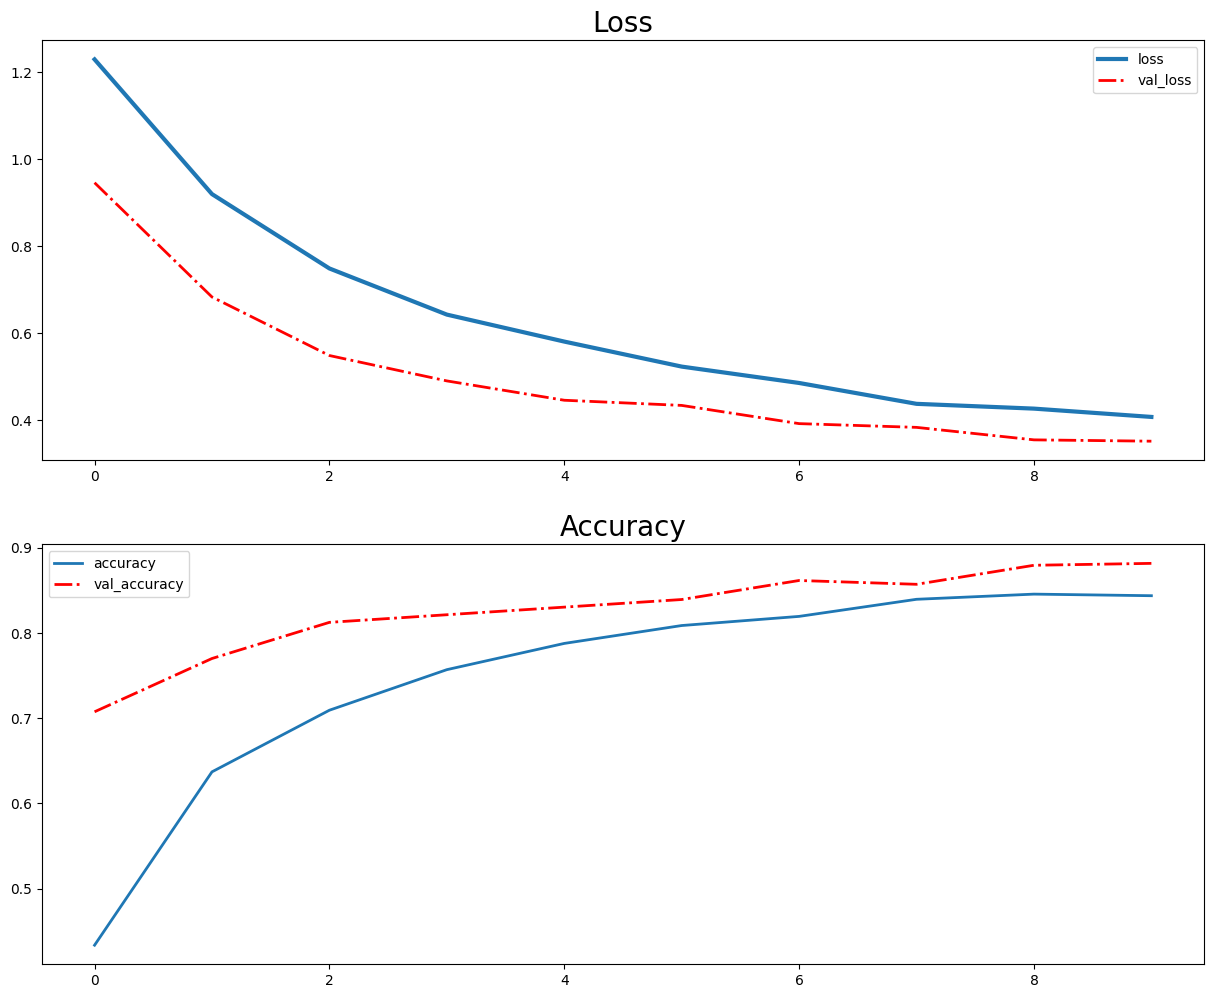

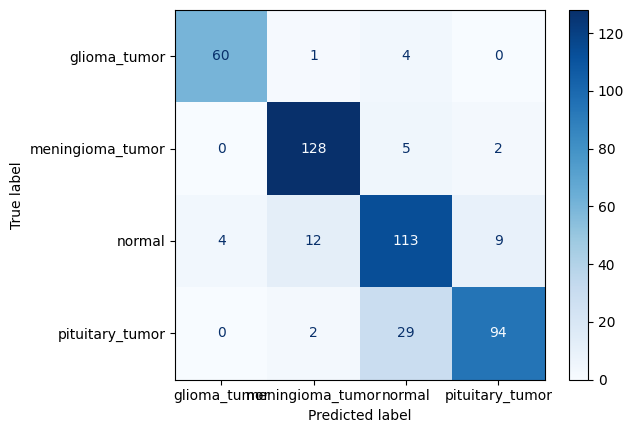

Classification Report
              precision    recall  f1-score   support

           0    0.93750   0.92308   0.93023        65
           1    0.89510   0.94815   0.92086       135
           2    0.74834   0.81884   0.78201       138
           3    0.89524   0.75200   0.81739       125

    accuracy                        0.85313       463
   macro avg    0.86905   0.86052   0.86262       463
weighted avg    0.85735   0.85313   0.85286       463



In [51]:
model_name = 'efficientnetv2b3_augmentation_not_trainable'
input_shape = (224,224,3)
aug_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_nt, history_aug_b3_nt = train(aug_b3_nt, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_nt, test_loss, test_acc, test_f1score = plot(aug_b3_nt, history_aug_b3_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2M

#### trainable first25

Epoch 1/10


2024-10-12 13:43:09.263581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_44/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 1.0591 - accuracy: 0.5639 - f1_score: 0.5421

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 97s 293ms/step - loss: 1.0591 - accuracy: 0.5639 - f1_score: 0.5421 - val_loss: 0.6539 - val_accuracy: 0.7723 - val_f1_score: 0.7669 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 15s 222ms/step - loss: 0.4146 - accuracy: 0.8745 - f1_score: 0.8730 - val_loss: 0.3354 - val_accuracy: 0.8973 - val_f1_score: 0.8972 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 15s 230ms/step - loss: 0.2006 - accuracy: 0.9426 - f1_score: 0.9451 - val_loss: 0.2985 - val_accuracy: 0.9174 - val_f1_score: 0.9164 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 15s 231ms/step - loss: 0.1053 - accuracy: 0.9678 - f1_score: 0.9668 - val_loss: 0.1769 - val_accuracy: 0.9598 - val_f1_score: 0.9621 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 13s 198ms/step - loss: 0.0598 - accuracy: 0.9841 - f1_score: 0.9852 - val_loss: 0.1630 - val_accuracy: 0.9598 - val_f1_score: 0.9638 - lr: 1.0000e-04
E

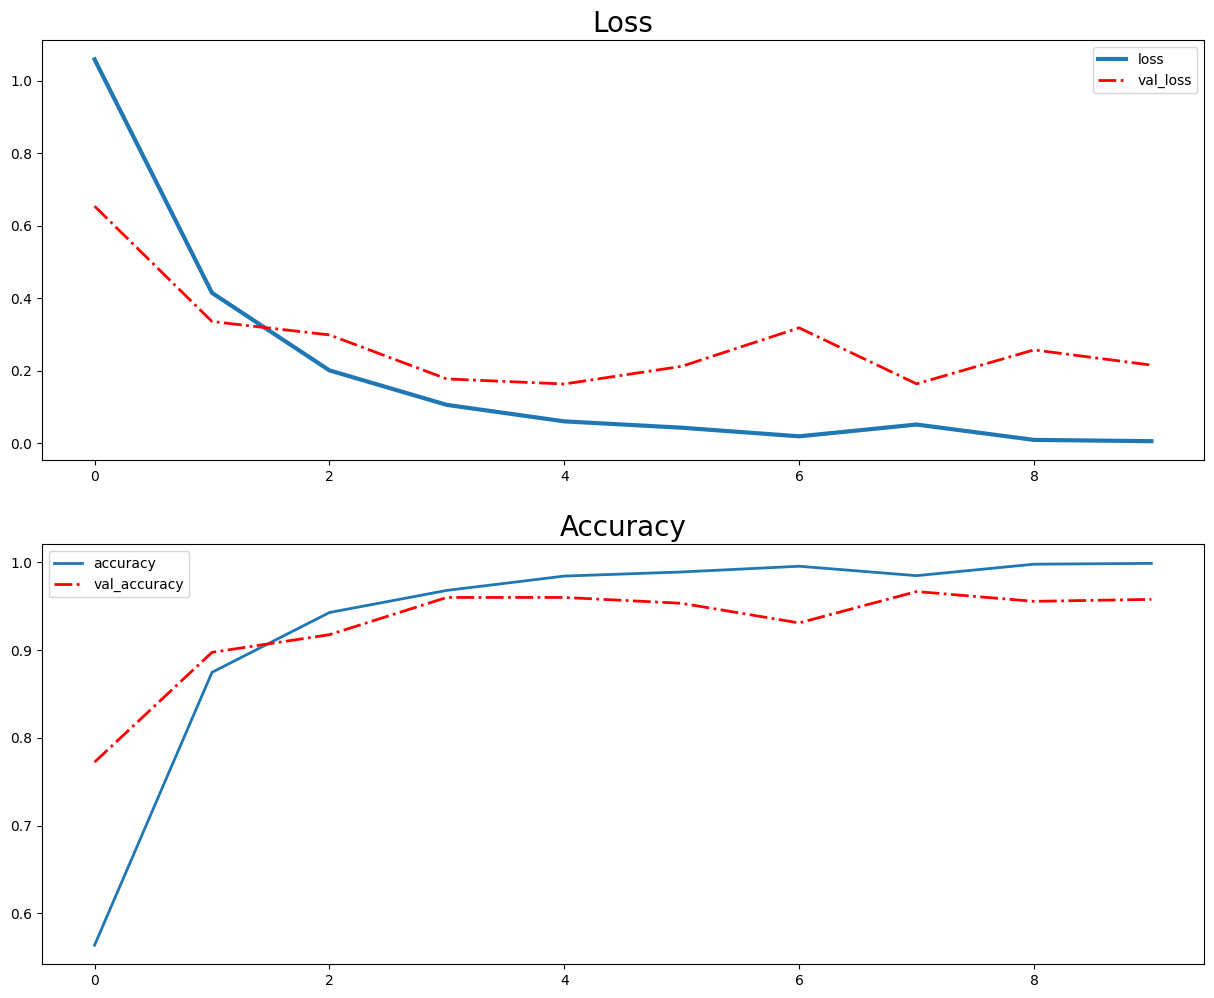

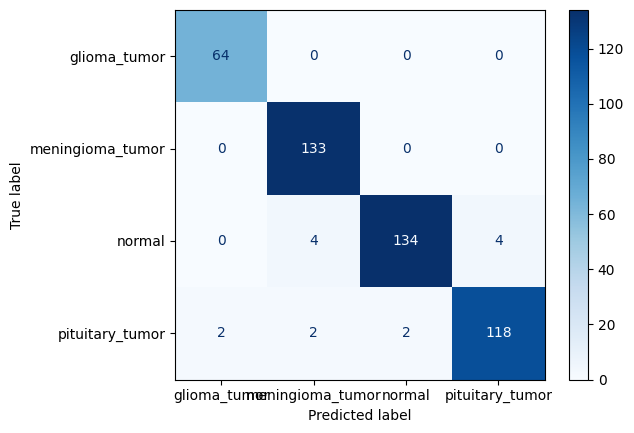

Classification Report
              precision    recall  f1-score   support

           0    0.96970   1.00000   0.98462        64
           1    0.95683   1.00000   0.97794       133
           2    0.98529   0.94366   0.96403       142
           3    0.96721   0.95161   0.95935       124

    accuracy                        0.96976       463
   macro avg    0.96976   0.97382   0.97148       463
weighted avg    0.97012   0.96976   0.96962       463



In [52]:
model_name = 'efficientnetv2m_augmentation_trainable_first25'
input_shape = (224,224,3)

aug_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tf25, history_aug_m_tf25 = train(aug_m_tf25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_m_tf25, test_loss, test_acc, test_f1score = plot(aug_m_tf25, history_aug_m_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-12 13:46:59.313856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7999 - accuracy: 0.6660 - f1_score: 0.6691

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 67s 240ms/step - loss: 0.7999 - accuracy: 0.6660 - f1_score: 0.6691 - val_loss: 0.3417 - val_accuracy: 0.8996 - val_f1_score: 0.9027 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 11s 163ms/step - loss: 0.2847 - accuracy: 0.8937 - f1_score: 0.8999 - val_loss: 0.2901 - val_accuracy: 0.9219 - val_f1_score: 0.9209 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 7s 103ms/step - loss: 0.1471 - accuracy: 0.9529 - f1_score: 0.9573 - val_loss: 0.2659 - val_accuracy: 0.9196 - val_f1_score: 0.9230 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 6s 90ms/step - loss: 0.1057 - accuracy: 0.9608 - f1_score: 0.9620 - val_loss: 0.3733 - val_accuracy: 0.9129 - val_f1_score: 0.9097 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 13s 198ms/step - loss: 0.0709 - accuracy: 0.9748 - f1_score: 0.9762 - val_loss: 0.2400 - val_accuracy: 0.9509 - val_f1_score: 0.9525 - lr: 1.0000e-04
Epoc

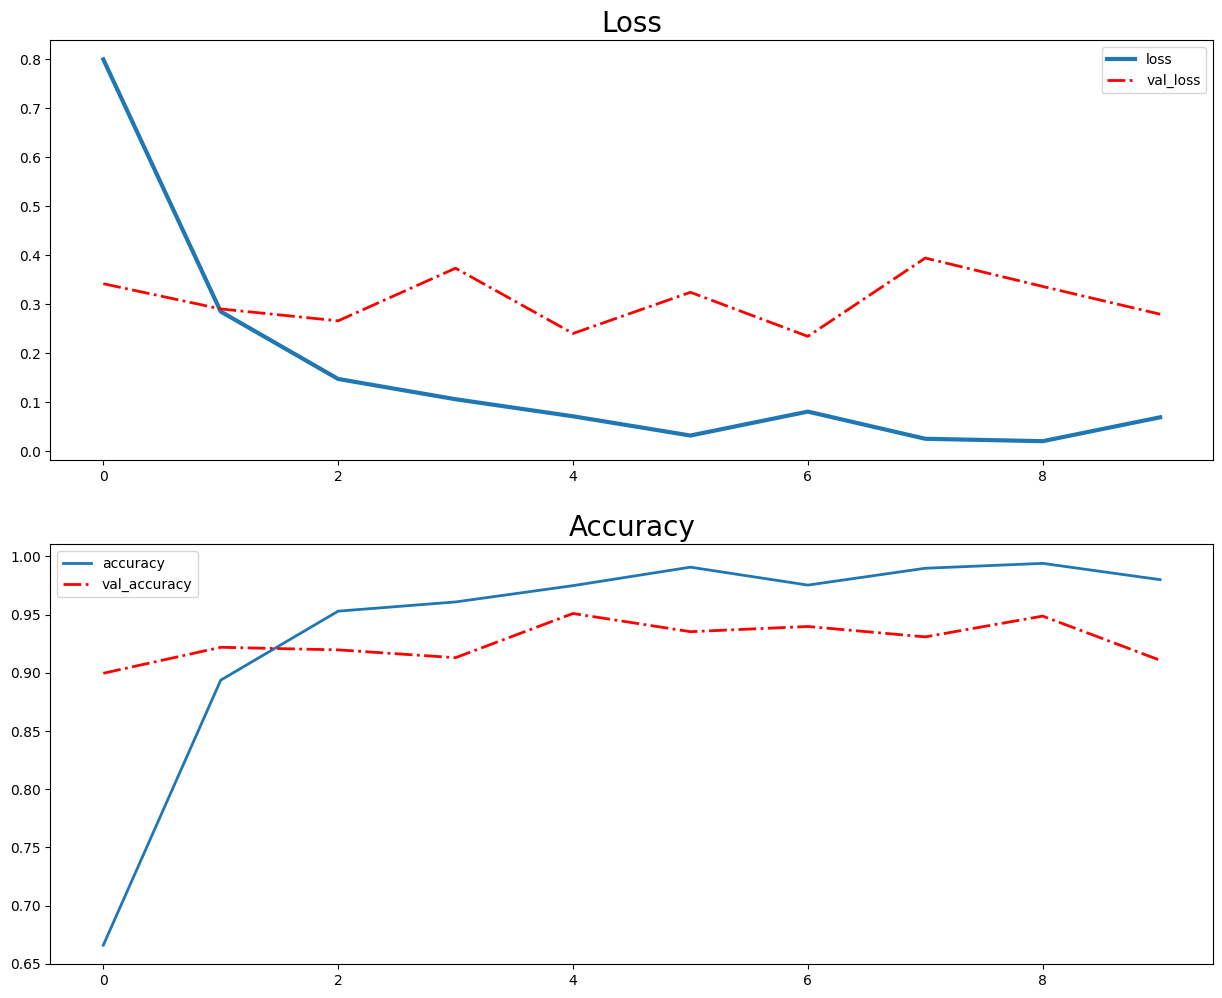

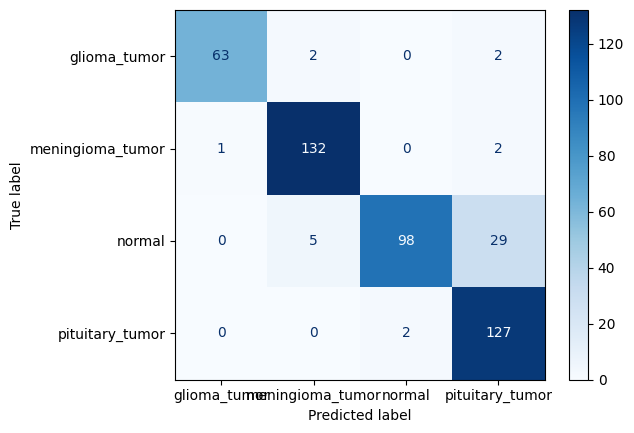

Classification Report
              precision    recall  f1-score   support

           0    0.98438   0.94030   0.96183        67
           1    0.94964   0.97778   0.96350       135
           2    0.98000   0.74242   0.84483       132
           3    0.79375   0.98450   0.87889       129

    accuracy                        0.90713       463
   macro avg    0.92694   0.91125   0.91226       463
weighted avg    0.91989   0.90713   0.90585       463



In [53]:
model_name = 'efficientnetv2m_augmentation_trainable_last25'
input_shape = (224,224,3)

aug_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tl25, history_aug_m_tl25 = train(aug_m_tl25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_m_tl25, test_loss, test_acc, test_f1score = plot(aug_m_tl25, history_aug_m_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.2491 - accuracy: 0.4249 - f1_score: 0.3682

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 29s 159ms/step - loss: 1.2491 - accuracy: 0.4249 - f1_score: 0.3682 - val_loss: 1.0549 - val_accuracy: 0.5893 - val_f1_score: 0.4743 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - 6s 88ms/step - loss: 1.0177 - accuracy: 0.5816 - f1_score: 0.5583 - val_loss: 0.8430 - val_accuracy: 0.6942 - val_f1_score: 0.6753 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - 7s 103ms/step - loss: 0.8592 - accuracy: 0.6628 - f1_score: 0.6596 - val_loss: 0.7061 - val_accuracy: 0.7768 - val_f1_score: 0.7755 - lr: 1.0000e-04
Epoch 4/10
67/67 [==============================] - 6s 85ms/step - loss: 0.7612 - accuracy: 0.7141 - f1_score: 0.7158 - val_loss: 0.6202 - val_accuracy: 0.8036 - val_f1_score: 0.8056 - lr: 1.0000e-04
Epoch 5/10
67/67 [==============================] - 6s 82ms/step - loss: 0.6797 - accuracy: 0.7458 - f1_score: 0.7506 - val_loss: 0.5696 - val_accuracy: 0.8170 - val_f1_score: 0.8182 - lr: 1.0000e-04
Epoch 6/

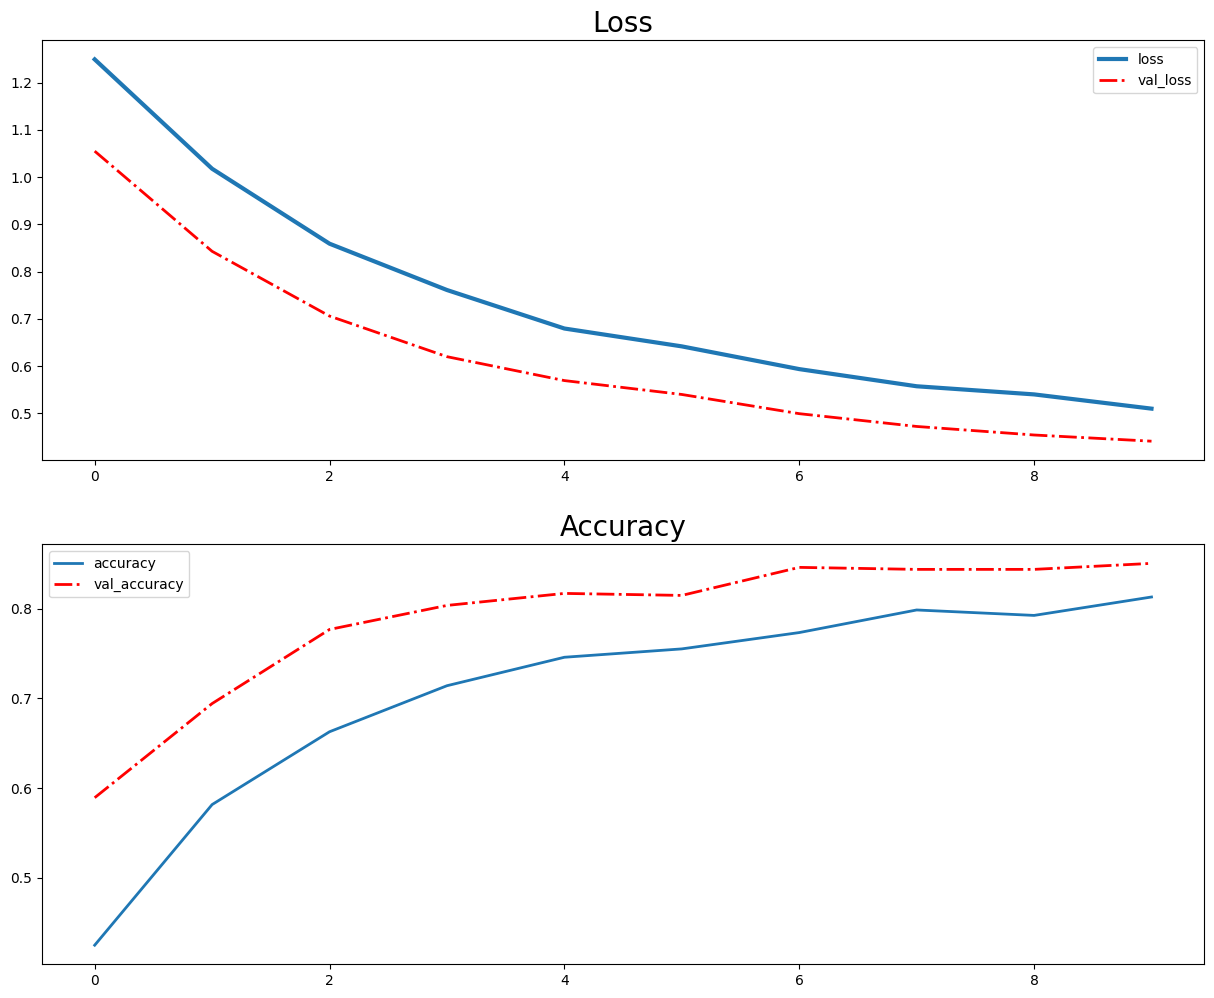

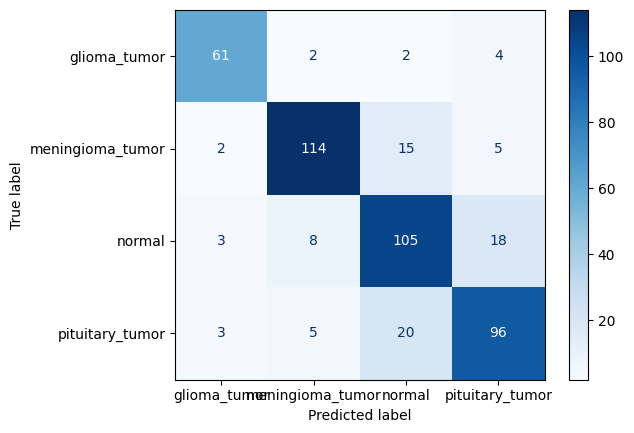

Classification Report
              precision    recall  f1-score   support

           0    0.88406   0.88406   0.88406        69
           1    0.88372   0.83824   0.86038       136
           2    0.73944   0.78358   0.76087       134
           3    0.78049   0.77419   0.77733       124

    accuracy                        0.81210       463
   macro avg    0.82193   0.82002   0.82066       463
weighted avg    0.81437   0.81210   0.81287       463



In [54]:
model_name = 'efficientnetv2m_augmentation_not_trainable'
input_shape = (224,224,3)

aug_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_nt, history_aug_m_nt = train(aug_m_nt, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_m_nt, test_loss, test_acc, test_f1score = plot(aug_m_nt, history_aug_m_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

# Result

In [56]:
results = pd.DataFrame(result_dict)
print(results)

                                         Model Name  Test Loss  Test Accuracy  \
0       efficientnetv2b0_standart_trainable_first25   0.081078       0.971922   
1        efficientnetv2b0_standart_trainable_last25   0.450822       0.913607   
2           efficientnetv2b0_standart_not_trainable   0.401576       0.848812   
3       efficientnetv2b3_standart_trainable_first25   0.133287       0.974082   
4        efficientnetv2b3_standart_trainable_last25   0.276641       0.933045   
5           efficientnetv2b3_standart_not_trainable   0.386621       0.850972   
6        efficientnetv2m_standart_trainable_first25   0.070455       0.976242   
7         efficientnetv2m_standart_trainable_last25   0.216692       0.939525   
8            efficientnetv2m_standart_not_trainable   0.497135       0.807775   
9   efficientnetv2b0_augmentation_trainable_first25   0.244363       0.937365   
10   efficientnetv2b0_augmentation_trainable_last25   0.254168       0.928726   
11      efficientnetv2b0_aug

# Testing using Different Dataset

In [89]:
def evaluate_model_on_dataset(model, dataset, class_names):
    # y_true = []
    # y_pred = []

    # test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)
    
    # # Iterate over the dataset
    # for images, labels in dataset:
    #     # Get true labels
    #     y_true.extend(np.argmax(labels.numpy(), axis=1))
        
    #     # Predict using the model
    #     predictions = model.predict(images)
    #     y_pred.extend(np.argmax(predictions, axis=1))
    
    # # Ensure y_true and y_pred have the same length
    # assert len(y_true) == len(y_pred), f"Length mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}"
    
    # # Generate confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    
    # # Plot confusion matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.title('Confusion Matrix')
    # plt.show()

    # # Generate classification report
    # report = classification_report(y_true, y_pred, target_names=class_names)
    # print(f"Classification Report:\n{report}")




    class_names = sorted(class_names)

    model.evaluate(dataset)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)
    
    return cm, cr

In [90]:
def load_new_dataset(dataset_dir, image_size=(224, 224), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='categorical',  # Assuming the dataset has multiple classes
        class_names=[class_name for class_name in os.listdir(dataset_dir)],
        seed=42,
        image_size=image_size,  # Automatically resizes images to 224x224
        batch_size=batch_size,
        shuffle=False  # Turn off shuffle for evaluation
    )
    return dataset

In [91]:
def load_best_model(model_path):
    return tf.keras.models.load_model(model_path)

Found 3055 files belonging to 4 classes.
1/1 [==============================] - 1s 1s/step


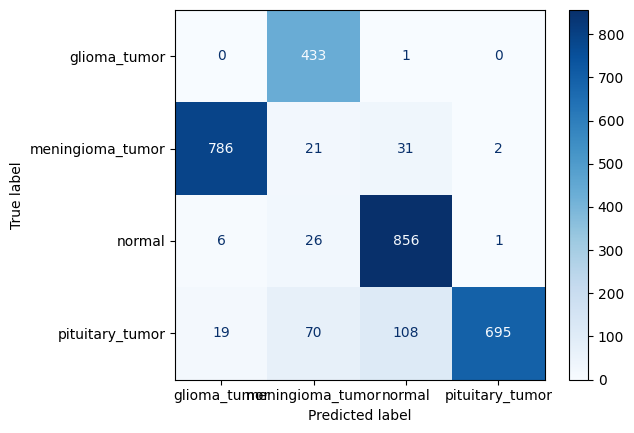

Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       434
           1    0.03818   0.02500   0.03022       840
           2    0.85944   0.96288   0.90822       889
           3    0.99570   0.77915   0.87421       892

    accuracy                        0.51457      3055
   macro avg    0.47333   0.44176   0.45316      3055
weighted avg    0.55132   0.51457   0.52785      3055



(array([[  0, 433,   1,   0],
        [786,  21,  31,   2],
        [  6,  26, 856,   1],
        [ 19,  70, 108, 695]]),
 '              precision    recall  f1-score   support\n\n           0    0.00000   0.00000   0.00000       434\n           1    0.03818   0.02500   0.03022       840\n           2    0.85944   0.96288   0.90822       889\n           3    0.99570   0.77915   0.87421       892\n\n    accuracy                        0.51457      3055\n   macro avg    0.47333   0.44176   0.45316      3055\nweighted avg    0.55132   0.51457   0.52785      3055\n')

In [92]:
# 1. Load the best model (replace 'path_to_best_model.h5' with the actual model file path)
best_model = load_best_model(CWD+'/model/model_efficientnetv2b0_standart_trainable_first25.h5')

# 2. Load the new dataset (replace 'path_to_new_dataset' with the actual dataset directory)
new_dataset = load_new_dataset(CWD + '/dataset/processed')

class_names = new_dataset.class_names

# 4. Evaluate the model and generate confusion matrix and classification report
evaluate_model_on_dataset(best_model, new_dataset, class_names)